In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from tqdm import tqdm

Modulesfolder = "../Modules/"
FiguresFolder = "./Figures/"

import sys
sys.path.append(Modulesfolder)


#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
from functools import partial

#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)



fig = plt.figure()
#plt.plot()
mpl.style.use('default')
rcParams = {
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "lightgray",
    "axes.edgecolor": "black",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "legend.facecolor":'lightgray',
    "legend.edgecolor":'black',
    'axes.titlecolor': 'white'}

def set_style(filename = None,folder=FiguresFolder,figure = None):
    if figure is None:
        global fig
        figure = fig

    #mpl.style.use('default')
    #plt.rcParams.update(rcParams)
    figure.patch.set_alpha(0.)
    if filename is not None:
        plt.savefig(folder+filename+'.png', facecolor=figure.get_facecolor(),bbox_inches='tight')

FS = 18 # fontsize


import warnings
warnings.simplefilter("ignore", UserWarning)

def to_date(time_array,offset_date='2000-01-01T00:00:00'):
    return np.array([pd.Timedelta(x,'days').round('d')+pd.Timestamp(offset_date) for x in time_array])

<Figure size 432x288 with 0 Axes>

In [2]:
from Modules.datasets.Reverberating_Damped_Random_Walk import Masking
import scipy

from scipy import stats
from Modules.datasets.Reverberating_Damped_Random_Walk import Masking


def sample_time_stamps(Poisson_scale, Expected_duration, random_seed=42):
    time_diff_sampler = scipy.stats.expon(scale=Poisson_scale)

    # Elementary Renewal theorem for Poisson process
    size = round(Expected_duration / Poisson_scale)

    # time steps between observations
    time_diffs = time_diff_sampler.rvs(size=size, random_state=random_seed)

    # time of observation
    time_array = np.append([0], np.cumsum(time_diffs))

    # timespan cutoff
    return time_array


rng = np.random.default_rng(seed=42)
border_gap_sampler = Masking.get_truncnorm_sampler(72, 25, 0, np.inf, rng)


def border_gaps_masks(time_arrays):
    start_gap_masks, end_gap_masks = Masking.sample_border_masks(time_arrays, border_gap_sampler)
    return start_gap_masks, end_gap_masks


from Modules.Gaussian_process import RDRW, RDRW_optimization, Utils

target_Poisson_scale = 2.5
context_Poisson_scale = 5

log_corr_bounds = (1.8, 3.4)
log_rev_bounds = (0.6, 1.8)


def simulate_context(years, Mean, Var, tau, rho, seed, err=None):
    assert log_corr_bounds[0] < np.log10(tau) and np.log10(tau) < log_corr_bounds[1]
    assert log_rev_bounds[0] < np.log10(rho) and np.log10(rho) < log_rev_bounds[1]

    time = sample_time_stamps(target_Poisson_scale, years * 365, 7)
    params_GT = np.array([Mean, Var, tau, rho])

    LC_sampler = RDRW.get_GP_sampler(time, *params_GT[2:4], Curve_type='RDRW')
    light_gt = LC_sampler(*params_GT[:2], random_seed=seed)

    if err is None:
        err = 0.01 * (light_gt.max() - light_gt.min())
    noise = np.random.normal(0, err, size=light_gt.shape)

    num_years = int(time.max() // 365)

    gaps = border_gap_sampler(2 * num_years).reshape(2, num_years)
    gaps[0] += (np.arange(num_years) * 365)
    gaps[1] = (np.arange(1, 1 + num_years) * 365) - gaps[1]

    gaps_masks = ((time[None, :] > gaps[0, :, None]) & (time[None, :] < gaps[1, :, None])).sum(0).astype(bool)

    subsampling_mask = Masking.Poisson_process_subsampling_mask(1 / target_Poisson_scale, 1 / context_Poisson_scale,
                                                                time.shape, rng)

    target = pd.DataFrame(np.array([time, light_gt + noise, light_gt, noise, err * np.ones_like(time),
                                    gaps_masks, subsampling_mask]).T,
                          columns=['time', 'light_noisy', 'light', 'noise', 'err', 'gaps_mask', 'subsampling_mask'])

    mask = gaps_masks & subsampling_mask
    context = target[mask].iloc[:, :-2]
    context.reset_index(inplace=True)
    context.rename(columns={'index': 'target_index'}, inplace=True)
    context = context.iloc[:, [1, 2, 3, 4, 5, 0]]

    return context, target, params_GT

In [3]:
from Modules.datasets.Reverberating_Damped_Random_Walk import Masking
import scipy

from scipy import stats

def get_DRW_Loss(time_array,Light_curve,Light_curve_errs):

    @jax.jit
    def Loss_DRW(Arguments):

        Mean,Descaled_logVariance,log_Correlation_time = Arguments

        Correlation_time = jnp.power(10,log_Correlation_time)
        Variance=jnp.power(10,Descaled_logVariance)*Correlation_time
        #Variance = jnp.power(10, Descaled_logVariance)

        NLL= RDRW_optimization.NegLogLikelihood(time_array,Light_curve,Light_curve_errs,Mean,Variance,Correlation_time,1.,Curve_type='DRW',Normalised=True)

        return NLL

    return Loss_DRW

def optimize_DRW(time_array,Light_curve,Light_curve_errs):
    loss_DRW = get_DRW_Loss(time_array,Light_curve,Light_curve_errs)

    Descaled_Variance = Light_curve.var() / np.power(10,2.6)
    initial_guess = [Light_curve.mean(),jnp.log10(Descaled_Variance),2.6]

    bounds_DRW=scipy.optimize.Bounds(lb = np.array((Light_curve.min(),-np.inf,np.log10(np.diff(time_array).min()))),
                             ub = np.array((Light_curve.max(),np.inf, 3.4)), keep_feasible=True)


    grad = jax.grad(loss_DRW)
    Loss = lambda x: loss_DRW(x).item()
    Grad = lambda x: np.array(grad(x))

    res=scipy.optimize.minimize(Loss,initial_guess,method='TNC',jac=Grad,
                                    bounds=bounds_DRW)


    Mean,Descaled_logVariance,log_Correlation_time = res.x

    Correlation_time = jnp.power(10,log_Correlation_time)
    Variance=jnp.power(10,Descaled_logVariance)*Correlation_time


    label= np.array([Mean,Variance,Correlation_time])
    return label

def merged_curves(time_delay,magnification,context):

    time = jnp.append(context['time'].values,context['time'].values+time_delay)
    light = jnp.append(context['light_0'].values,context['light_1'].values-magnification)
    err = jnp.append(context['err'].values,context['err'].values)

    return time,light,err


def loss(lensing,labels):
    time_delay,magnification,mean,variance = lensing

    time,light,err = merged_curves(time_delay,magnification,context)

    return RDRW_optimization.NegLogLikelihood(time,light,err,mean,variance,*labels[2:])

In [4]:
_ = simulate_context(5,0.,1,600,18,8)

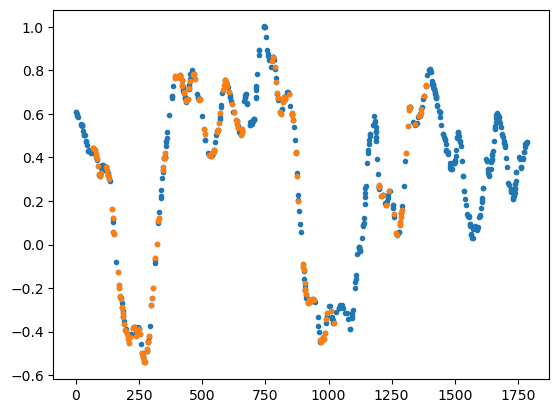

In [5]:
context,target,params_GT = simulate_context(5,0.,1,600,18,8)
plt.scatter(target['time'],target['light'],marker='.')
plt.scatter(context['time'],context['light'],marker='.')

In [6]:
from Modules.Gaussian_process.Utils import Optimizer


optimizer = Optimizer(context['time'].values, context['light'].values, np.zeros_like(context['light'].values),
                                  normalisation='day',report_learning=False)

result,_ = optimizer.optimize()

In [7]:
mean, var = RDRW.predict(target['time'].values, context['time'].values, context['light'].values, np.zeros_like(context['light'].values), *result,return_cov_matrix=True)

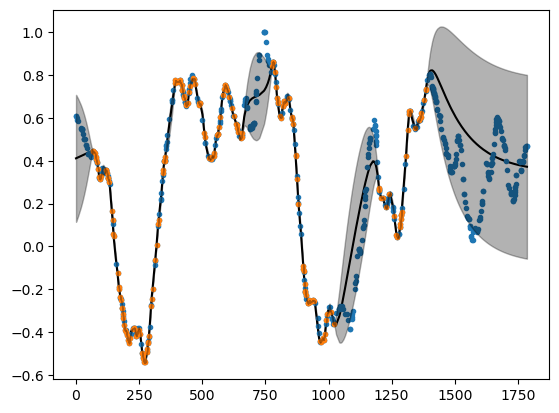

In [8]:
plt.scatter(*target[['time','light']].values.T,marker='.',color='C0')

plt.scatter(*context[['time','light']].values.T,marker='.',color='C1')

plt.plot(target['time'],mean,color='k',zorder=0)
plt.fill_between(target['time'],mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='k')

In [9]:
suggestions = optimizer._prepare_for_optimization()
suggestions

(array([ 0.24210774, -0.76992486,  0.03770714, -1.31229286]),
 array([-0.54197231,        -inf, -0.76229285,        -inf]),
 array([ 0.86170481,         inf,         inf, -0.76229287]))

In [10]:
Loss_RDRW = optimizer.compile_loss()

def labels_to_args(labels):
    Mean,Variance,Corr_time,Rev_time = labels
    Arguments = np.array([Mean,np.log10(Variance/(Corr_time+Rev_time)*365),np.log10(Corr_time/365),np.log10(Rev_time/365)])
    return Arguments


def loss(labels):
    Arguments = labels_to_args(labels)
    return Loss_RDRW(Arguments).item()

In [11]:
true_labels = (0.,1,600,18)
true_args = labels_to_args(true_labels)
#true_args = np.array([0,np.log10(1/(600+18)*365),np.log10(600/365),np.log10(18/365)])

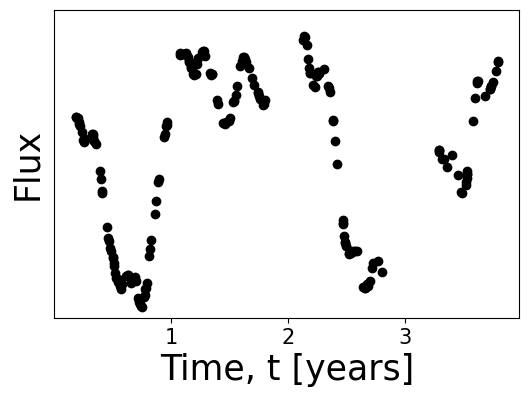

In [13]:
fig,ax = plt.subplots(figsize=(6,4))

plt.scatter(context['time']/365,context['light'],color='k',label='Observed data, '+r'$\vec{x}(\vec{t})$')
#plt.plot(target['time']/365,target['light'],color='k',linestyle='--',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)

#plt.plot(target['time']/365,mean,color='C1',zorder=0,label='Gaussian process, '+r'$f^{\ast}(\vec{t}^{\ast})$')
#plt.fill_between(target['time']/365,mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})


plt.ylabel('Flux',fontsize=25)
plt.xlabel('Time, t [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks([])
#plt.legend(fontsize=FS,loc='upper left',framealpha=1)
plt.ylim(-0.6,1.)

fig.patch.set_alpha(0.)

#set_style()
set_style(filename='GP_fit_example_no_GP')

In [14]:
grid = np.arange(context['time'].min(),context['time'].max())
spline = np.interp(grid,context['time'],context['light'])

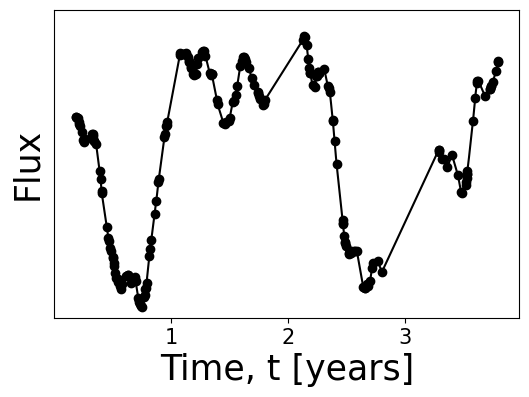

In [17]:
fig,ax = plt.subplots(figsize=(6,4))

plt.scatter(context['time']/365,context['light'],color='k',label='Observed data, '+r'$\vec{x}(\vec{t})$')
plt.plot(grid/365,spline,color='k',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)
#plt.plot(target['time']/365,target['light'],color='k',linestyle='--',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)

#plt.plot(target['time']/365,mean,color='C1',zorder=0,label='Gaussian process, '+r'$f^{\ast}(\vec{t}^{\ast})$')
#plt.fill_between(target['time']/365,mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})


plt.ylabel('Flux',fontsize=25)
plt.xlabel('Time, t [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks([])
#plt.legend(fontsize=FS,loc='upper left',framealpha=1)
plt.ylim(-0.6,1.)

fig.patch.set_alpha(0.)

set_style(filename='GP_fit_example_spline')

In [43]:
freq = np.fft.rfftfreq(len(grid))
spline_spec = np.abs(scipy.fft.rfft(spline,norm='ortho'))**2
spline_spec/=spline_spec[1]

In [44]:
true_labels

(0.0, 1, 600, 18)

In [45]:
true_spec = 1/((1+(2*np.pi*freq*true_labels[-2])**2)*(1+(2*np.pi*freq*true_labels[-1])**2))
true_spec/=true_spec[1]

/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_5312/1987443114.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(spline_spec))
/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_5312/1987443114.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(true_spec))


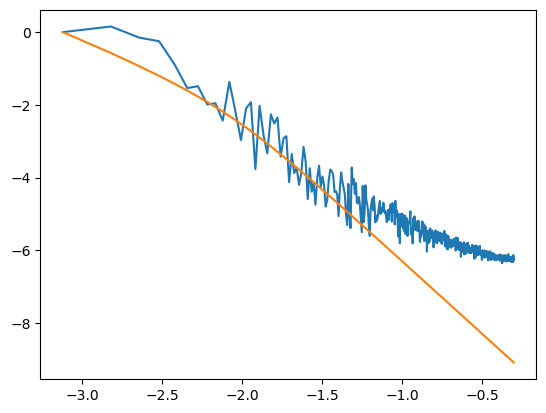

In [46]:
plt.plot(np.log10(freq),np.log10(spline_spec))
plt.plot(np.log10(freq),np.log10(true_spec))

In [47]:
result

array([  0.3453189 ,   0.18450142, 123.64454309,  18.48686388])

In [52]:
pred_spec = 1/((1+(2*np.pi*freq*600)**2)*(1+(2*np.pi*freq*50)**2))
pred_spec/=pred_spec[1]

/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_5312/4221560781.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth')
/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_5312/4221560781.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction')


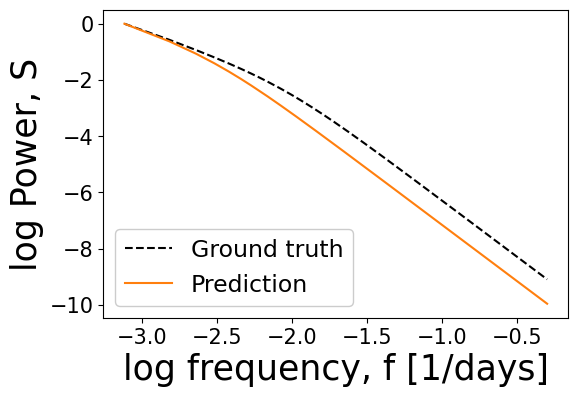

In [53]:
fig,ax = plt.subplots(figsize=(6,4))

plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth')
plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction')


plt.ylabel('log Power, S',fontsize=25)
plt.xlabel('log frequency, f [1/days]',fontsize=25)
#ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17,loc='lower left',framealpha=1)
#plt.ylim(-0.6,1.)
#set_style()

fig.patch.set_alpha(0.)
set_style(filename='Spec_fit_example_spline')

In [50]:
pred_spec = 1/((1+(2*np.pi*freq*600)**2)*(1+(2*np.pi*freq*result[-1])**2))
pred_spec/=pred_spec[1]

/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_5312/3800786773.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth',zorder=1)
/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_5312/3800786773.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction',zorder=0)


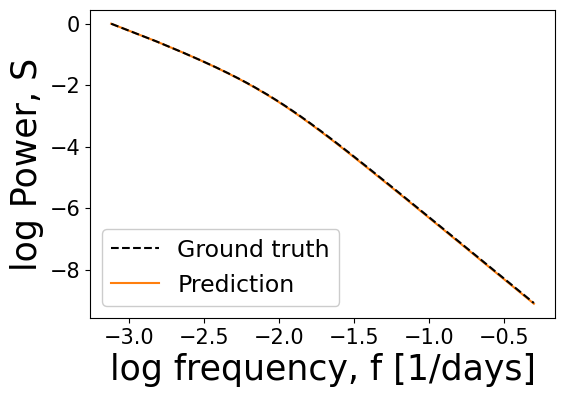

In [51]:
fig,ax = plt.subplots(figsize=(6,4))

plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth',zorder=1)
plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction',zorder=0)


plt.ylabel('log Power, S',fontsize=25)
plt.xlabel('log frequency, f [1/days]',fontsize=25)
#ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17,loc='lower left',framealpha=1)
#plt.ylim(-0.6,1.)
#set_style()

fig.patch.set_alpha(0.)
set_style(filename='Spec_fit_example_spline_ref')

In [36]:
mean, var = RDRW.predict(target['time'].values, context['time'].values, context['light'].values, np.zeros_like(context['light'].values), *true_labels,return_cov_matrix=True)

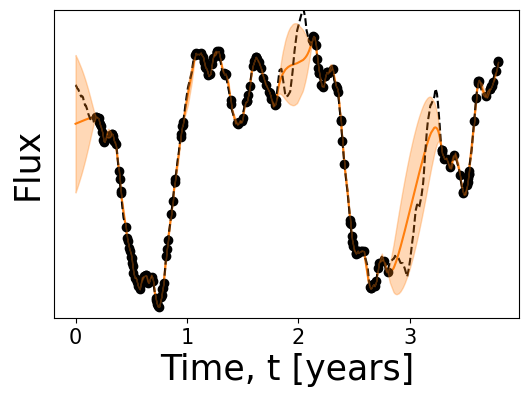

In [56]:
fig,ax = plt.subplots(figsize=(6,4))
mask = (target['time']<context['time'].max())
plt.scatter(context['time']/365,context['light'],color='k',label='Observed')
#plt.plot(grid/365,spline,color='k',linestyle='--',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)
plt.plot(target['time'][mask]/365,target['light'][mask],color='k',linestyle='--',label='Ground truth',zorder=1)


plt.plot(target['time'][mask]/365,mean[mask],color='C1',zorder=0,label='Gaussian process, '+r'$\mu(t), \ \sigma(t)$')
plt.fill_between(target['time'][mask]/365,mean[mask]+np.sqrt(np.diag(var))[mask],mean[mask]-np.sqrt(np.diag(var))[mask],alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})


plt.ylabel('Flux',fontsize=25)
plt.xlabel('Time, t [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks([])
#set_style()

ax.tick_params(axis='both', which='major', labelsize=15)
#plt.legend(fontsize=17,loc='lower left',framealpha=1)
#plt.ylim(-2.5,1.3)
plt.ylim(-0.6,1.)


fig.patch.set_alpha(0.)
#set_style(filename='GP_fit_example_interp')

# Lensing inference

<ErrorbarContainer object of 3 artists>

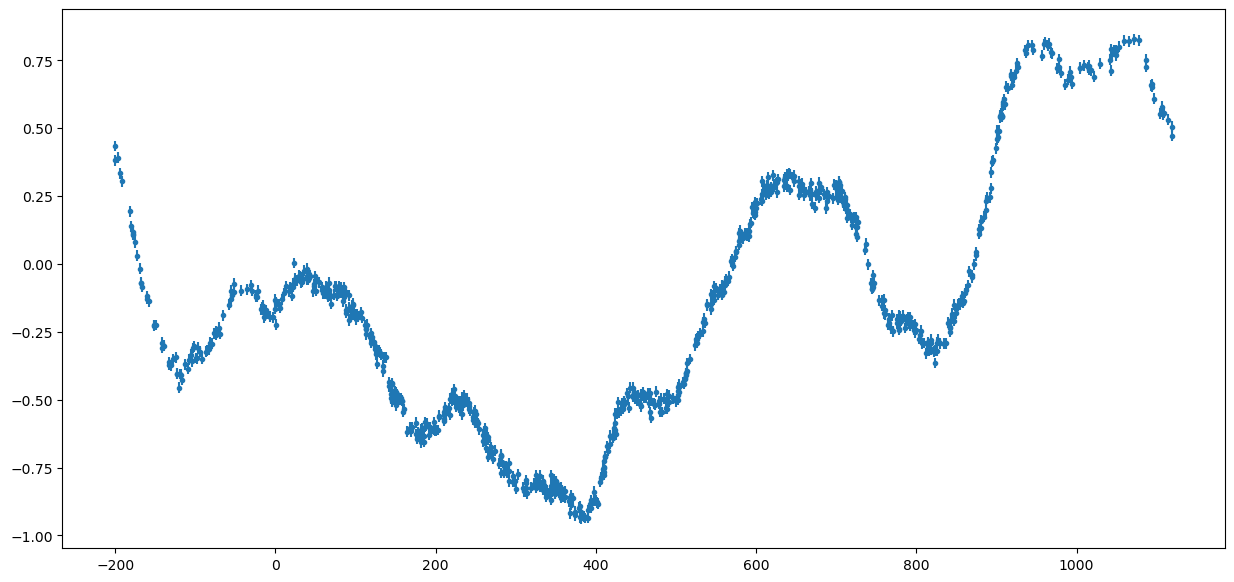

In [4]:
magnification = 2
time_delay = -200

time_obs = sample_time_stamps(2.5, 3*365, 7)
time_gt=np.append(time_obs,time_obs+time_delay)

params_GT=np.array([0,1,1000.,30.,magnification,time_delay])

LC_sampler = RDRW.get_GP_sampler(time_gt, *params_GT[2:4], Curve_type='RDRW')
light_gt = LC_sampler(*params_GT[:2], random_seed=3)
# err = 0.05
err = 0.02
# 0
noise_rng = np.random.default_rng(seed=3)
noise = noise_rng.normal(0,err,size=light_gt.shape)

target = pd.DataFrame(np.array([time_gt,light_gt + noise,noise,err*np.ones_like(time_gt),np.arange(len(time_gt))<len(time_obs)]).T,
                       columns=['time','light','noise','err','curve_index'])

fig = plt.subplots(figsize=(15,7))
plt.errorbar(target['time'],target['light'],target['err'],fmt='.')

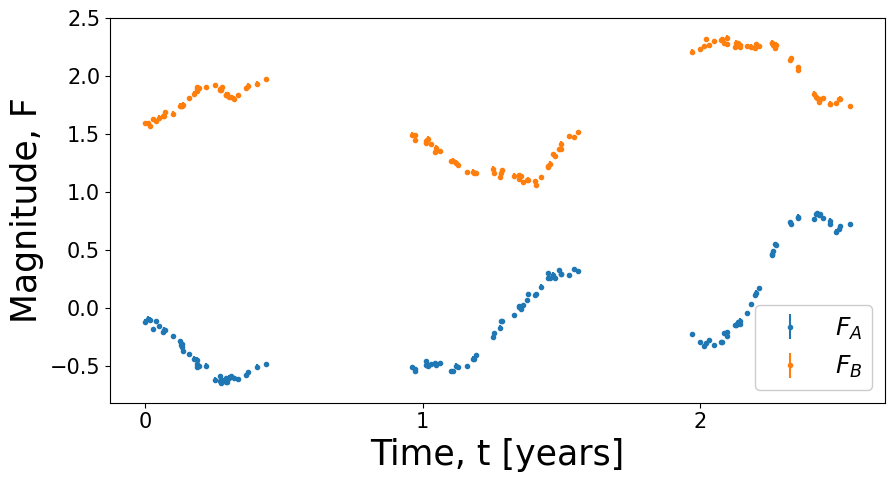

In [5]:
#18
# 3
rng = np.random.default_rng(seed=6)
border_gap_sampler = Masking.get_truncnorm_sampler(72, 25, 0, np.inf, rng)


def border_gaps_masks(time_arrays):
    start_gap_masks, end_gap_masks = Masking.sample_border_masks(time_arrays, border_gap_sampler)
    return start_gap_masks, end_gap_masks


gaps_lengths = border_gap_sampler(2 * (int(time_obs.max() / 365) + 1)).reshape(2, -1)

gaps_borders = np.array([gaps_lengths[0] + np.arange(gaps_lengths.shape[1]) * 365,
                         np.arange(1, gaps_lengths.shape[1] + 1) * 365 - gaps_lengths[1]]).T

no_gap_mask = np.array([(borders[0] < time_obs) & (time_obs < borders[1]) for borders in gaps_borders]).sum(0).astype(
    bool)

subsampling_mask = Masking.Poisson_process_subsampling_mask(1 / target_Poisson_scale, 1 / context_Poisson_scale,
                                                            time_obs.shape, rng)
context = pd.DataFrame(np.array([time_obs, target['light'][target['curve_index'].astype(bool)],
                                 target['light'][~target['curve_index'].astype(bool)] + params_GT[-2],
                                 target['err'][target['curve_index'].astype(bool)]]).T,
                       columns=['time', 'light_0', 'light_1', 'err'])

context = context[no_gap_mask & subsampling_mask]
min_time = context['time'].iloc[0]
context['time'] -= context['time'].iloc[0]
context = context.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10, 5))

ax.errorbar(context['time'] / 365, context['light_0'], context['err'], fmt='.', label=r'$F_A$')
ax.errorbar(context['time'] / 365, context['light_1'], context['err'], fmt='.', label=r'$F_B$')

#plt.plot(target['time']/365,mean,color='C1',zorder=0,label='Gaussian process, '+r'$f^{\ast}(\vec{t}^{\ast})$')
#plt.fill_between(target['time']/365,mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})
plt.ylabel('Magnitude, F', fontsize=25)
plt.xlabel('Time, t [years]', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=18, framealpha=1, loc='lower right')
plt.xticks([0, 1, 2,])
set_style()
#set_style(filename='lensed_example')

In [6]:
from Modules.Gaussian_process.Utils import Optimizer
optimizer_RDRW_0 = Optimizer(context['time'].values, context['light_0'].values, context['err'].values,
                                        *params_GT[2:4],
                                        normalisation='day',report_learning=False)

optimizer_RDRW_1 = Optimizer(context['time'].values, context['light_1'].values, context['err'].values,
                                        *params_GT[2:4],
                                         normalisation='day',report_learning=False)

RDRW_0,_ = optimizer_RDRW_0.optimize()
RDRW_1,_ = optimizer_RDRW_1.optimize()

res_DRW_0 = optimize_DRW(context['time'].values,context['light_0'].values,context['err'].values)
res_DRW_1 = optimize_DRW(context['time'].values,context['light_1'].values,context['err'].values)

In [7]:
res_DRW_0

array([1.70975965e-01, 2.27286006e-01, 1.08485407e+03])

In [8]:
res_DRW_1

array([1.70235012e+00, 7.82429750e-02, 5.38374750e+02])

In [9]:
query_times = np.append(np.arange(context['time'].min(),context['time'].max(),1),context['time'].values)

In [10]:
mean_true_0,variance_true_0 = RDRW.predict(query_times,context['time'].values,context['light_0'].values,
                                 context['err'].values,*params_GT[:-2],return_cov_matrix=True)

mean_true_1,variance_true_1 = RDRW.predict(query_times,context['time'].values,context['light_1'].values,
                                 context['err'].values,*params_GT[:-2],return_cov_matrix=True)

mean_true_temp_0,variance_true_temp_0 = RDRW.predict(query_times,context['time'].values,context['light_0'].values,
                                 context['err'].values,*RDRW_0,return_cov_matrix=True)

mean_true_temp_1,variance_true_temp_1 = RDRW.predict(query_times,context['time'].values,context['light_1'].values,
                                 context['err'].values,*RDRW_1,return_cov_matrix=True)

mean_DRW_0,variance_DRW_0 = RDRW.predict(query_times,context['time'].values,context['light_0'].values,
                                 context['err'].values,*res_DRW_0,Reverberation_time=0.,return_cov_matrix=True)

mean_DRW_1,variance_DRW_1 = RDRW.predict(query_times,context['time'].values,context['light_1'].values,
                                 context['err'].values,*res_DRW_1,Reverberation_time=0.,return_cov_matrix=True)

In [11]:
def plot_GP(mean,variance,ax,color,len,labels=[None,None],linewidth=2,**kwargs):
    line =ax.plot(query_times[:len]/365,mean[:len],color=color,label=labels[0],linewidth=linewidth,**kwargs)
    contour = ax.fill_between(query_times[:len]/365,mean[:len]+np.sqrt(np.diag(variance))[:len],mean[:len]-np.sqrt(np.diag(variance))[:len],
                   color=color,alpha=0.2,label=labels[1],**kwargs)
    return line,contour

In [12]:
length = len(query_times) - len(context['time'])

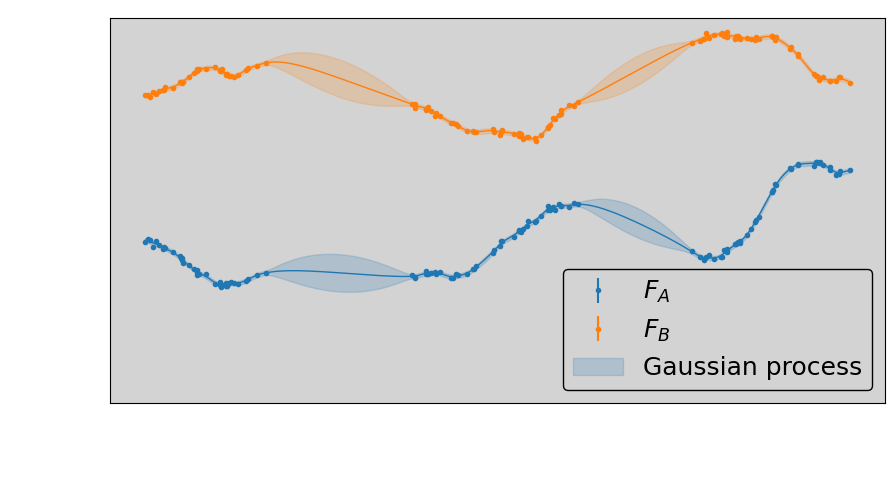

In [13]:
fig,ax = plt.subplots(figsize=(10,5))

q0=ax.errorbar(context['time']/365,context['light_0'],context['err'],fmt='.',label=r'$F_A$')
q1=ax.errorbar(context['time']/365,context['light_1'],context['err'],fmt='.',label=r'$F_B$')


line,contour = plot_GP(mean_true_0,variance_true_0,ax,color='C0',len=length,labels=['Gaussian process','Gaussian process'],linewidth=1,zorder=0)
plot_GP(mean_true_1,variance_true_1,ax,color='C1',len=length,linewidth=1,zorder=0)


plt.ylabel('Magnitude, F', fontsize=25)
plt.xlabel('Time, t [years]', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.legend([q0,q1,contour],[r'$F_A$',r'$F_B$','Gaussian process'],fontsize=18,framealpha=1,loc='lower right')
plt.xticks([0,1,2])
plt.ylim(-2,2.5)
set_style()
#set_style(filename='GP_lensed_example')

In [14]:
lensing_loss = jax.jit(lambda x: loss(x,RDRW_0))
grad = jax.grad(lensing_loss)
lensing_grad = lambda x: np.array(grad(x))

lensing_true_temp =scipy.optimize.minimize(lensing_loss,[time_delay,magnification,*RDRW_0[:2]],jac = lensing_grad,method='TNC')
lensing_true_temp.x

array([-2.00730446e+02,  1.99054123e+00,  4.57070607e-02,  8.22055755e-01])

In [15]:
lensing_loss = jax.jit(lambda x: loss(x,[0,0,1084,0]))
grad = jax.grad(lensing_loss)
lensing_grad = lambda x: np.array(grad(x))

lensing_DRW =scipy.optimize.minimize(lensing_loss,[time_delay,magnification,*res_DRW_0[:2]],jac = lensing_grad,method='Nelder-Mead')
lensing_DRW.x

/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/scipy/optimize/_minimize.py:550: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


array([-2.02724250e+02,  1.99866277e+00,  4.03664570e-02,  1.80781164e-01])

In [16]:
def plot_GP(mean,variance,ax,color,len,labels=[None,None],linewidth=2,time_shift = 0,**kwargs):
    line =ax.plot((query_times[:len]+time_shift)/365,mean[:len],color=color,label=labels[0],linewidth=linewidth,**kwargs)
    contour = ax.fill_between((query_times[:len]+time_shift)/365,mean[:len]+np.sqrt(np.diag(variance))[:len],mean[:len]-np.sqrt(np.diag(variance))[:len],
                   color=color,alpha=0.2,label=labels[1],**kwargs)
    return line,contour

FileNotFoundError: [Errno 2] No such file or directory: './Figures/GP_delensed_example.png'

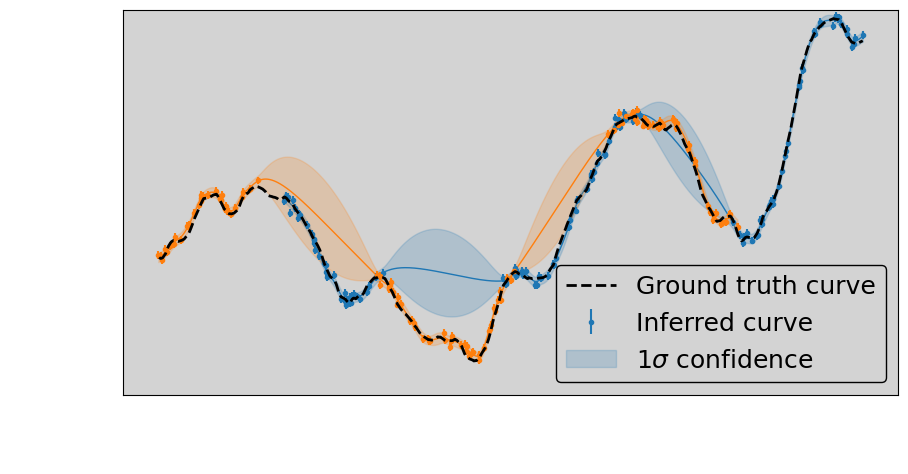

In [17]:
fig,ax = plt.subplots(figsize=(10,5))



q0=ax.errorbar(context['time']/365,context['light_0'],context['err'],fmt='.',label='A')
q1=ax.errorbar((context['time']+lensing_true_temp.x[0])/365,context['light_1']-lensing_true_temp.x[1],context['err'],fmt='.',label='B')


line,contour = plot_GP(mean_true_0,variance_true_0,ax,color='C0',len=length,labels=['Gaussian process','Gaussian process'],linewidth=1,zorder=0)
plot_GP(mean_true_1-lensing_true_temp.x[1],variance_true_1,ax,color='C1',len=length,linewidth=1,zorder=0,time_shift=lensing_true_temp.x[0])

q = np.argsort(target['time'])

mask_target = (target['time'][q]-min_time > -200) & (target['time'][q]-min_time < context['time'].max())
gt_line = ax.plot((target['time'][q][mask_target]-min_time)/365,(target['light']-target['noise'])[q][mask_target],color='k',linestyle='--',zorder = 6,linewidth = 2,label='ground truth')


plt.ylabel('Magnitude, F', fontsize=25)
plt.xlabel('Time, t [years]', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)


plt.ylabel('Magnitude, F',fontsize=25)
plt.xlabel('Time, t [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend([gt_line[0],q0,contour],['Ground truth curve','Inferred curve',r'$1\sigma$'+' confidence'],fontsize=18,framealpha=1,loc='lower right')
plt.xticks([0,1,2])
plt.ylim(-1.1,0.85)
set_style()
set_style(filename='GP_delensed_example')

In [18]:
context,target,params_GT = simulate_context(5,0.,1,540,5*4.6,8)

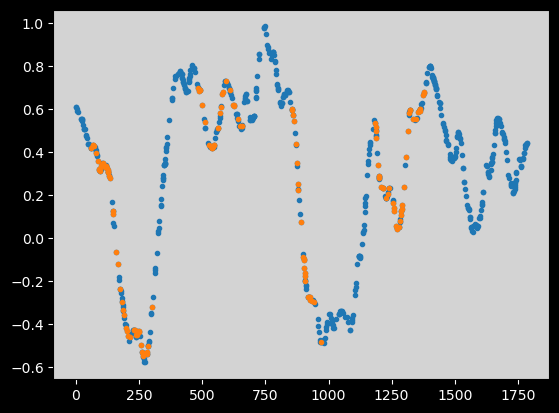

In [19]:
plt.scatter(target['time'],target['light'],marker='.')
plt.scatter(context['time'],context['light'],marker='.')

In [20]:
from Modules.Gaussian_process.Utils import Optimizer


optimizer = Optimizer(context['time'].values, context['light'].values, np.zeros_like(context['light'].values),
                                  normalisation='day',report_learning=False)

result,_ = optimizer.optimize()

In [21]:
mean, var = RDRW.predict(target['time'].values, context['time'].values, context['light'].values, np.zeros_like(context['light'].values), *result,return_cov_matrix=True)

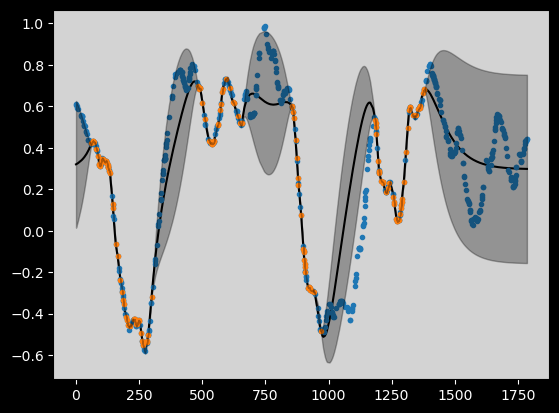

In [22]:
plt.scatter(*target[['time','light']].values.T,marker='.',color='C0')

plt.scatter(*context[['time','light']].values.T,marker='.',color='C1')

plt.plot(target['time'],mean,color='k',zorder=0)
plt.fill_between(target['time'],mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='k')

In [23]:
Loss_RDRW = optimizer.compile_loss()

def labels_to_args(labels):
    Mean,Variance,Corr_time,Rev_time = labels
    Arguments = np.array([Mean,np.log10(Variance/(Corr_time+Rev_time)*365),np.log10(Corr_time/365),np.log10(Rev_time/365)])
    return Arguments


def loss(labels):
    Arguments = labels_to_args(labels)
    return Loss_RDRW(Arguments).item()

In [24]:
true_labels = (0.,1,540,5*4.6)
true_args = labels_to_args(true_labels)
#true_args = np.array([0,np.log10(1/(600+18)*365),np.log10(600/365),np.log10(18/365)])

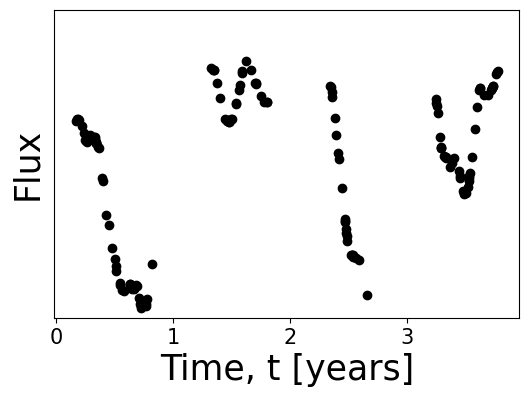

In [33]:
fig,ax = plt.subplots(figsize=(6,4))

plt.scatter(context['time']/365,context['light'],color='k',label='Observed data, '+r'$\vec{x}(\vec{t})$')
#plt.plot(target['time']/365,target['light'],color='k',linestyle='--',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)

#plt.plot(target['time']/365,mean,color='C1',zorder=0,label='Gaussian process, '+r'$f^{\ast}(\vec{t}^{\ast})$')
#plt.fill_between(target['time']/365,mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})


plt.ylabel('Flux',fontsize=25)
plt.xlabel('Time, t [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks([])
#plt.legend(fontsize=FS,loc='upper left',framealpha=1)
plt.ylim(-0.6,1.)

fig.patch.set_alpha(0.)

#set_style()
set_style(filename='GP_fit_example_no_GP')

In [34]:
grid = np.arange(context['time'].min(),context['time'].max())
spline = np.interp(grid,context['time'],context['light'])

In [17]:
_ = simulate_context(5,0.,1,600,18,8)

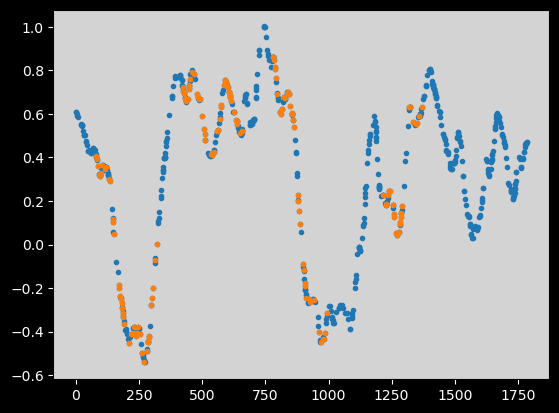

In [81]:
context,target,params_GT = simulate_context(5,0.,1,600,18,8)
plt.scatter(target['time'],target['light'],marker='.')
plt.scatter(context['time'],context['light'],marker='.')

In [82]:
from Modules.Gaussian_process.Utils import Optimizer


optimizer = Optimizer(context['time'].values, context['light'].values, np.zeros_like(context['light'].values),
                                  normalisation='day',report_learning=False)

result,_ = optimizer.optimize()

In [83]:
mean, var = RDRW.predict(target['time'].values, context['time'].values, context['light'].values, np.zeros_like(context['light'].values), *result,return_cov_matrix=True)

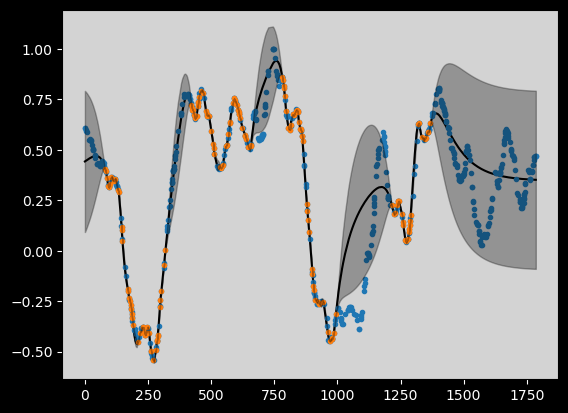

In [84]:
plt.scatter(*target[['time','light']].values.T,marker='.',color='C0')

plt.scatter(*context[['time','light']].values.T,marker='.',color='C1')

plt.plot(target['time'],mean,color='k',zorder=0)
plt.fill_between(target['time'],mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='k')

In [85]:
suggestions = optimizer._prepare_for_optimization()
suggestions

(array([ 0.26513422, -0.79777539,  0.03770714, -1.31229286]),
 array([-0.54156723,        -inf, -0.76229285,        -inf]),
 array([ 0.8602961 ,         inf,         inf, -0.76229287]))

In [86]:
Loss_RDRW = optimizer.compile_loss()

def labels_to_args(labels):
    Mean,Variance,Corr_time,Rev_time = labels
    Arguments = np.array([Mean,np.log10(Variance/(Corr_time+Rev_time)*365),np.log10(Corr_time/365),np.log10(Rev_time/365)])
    return Arguments


def loss(labels):
    Arguments = labels_to_args(labels)
    return Loss_RDRW(Arguments).item()

In [87]:
true_labels = (0.,1,600,18)
true_args = labels_to_args(true_labels)
#true_args = np.array([0,np.log10(1/(600+18)*365),np.log10(600/365),np.log10(18/365)])

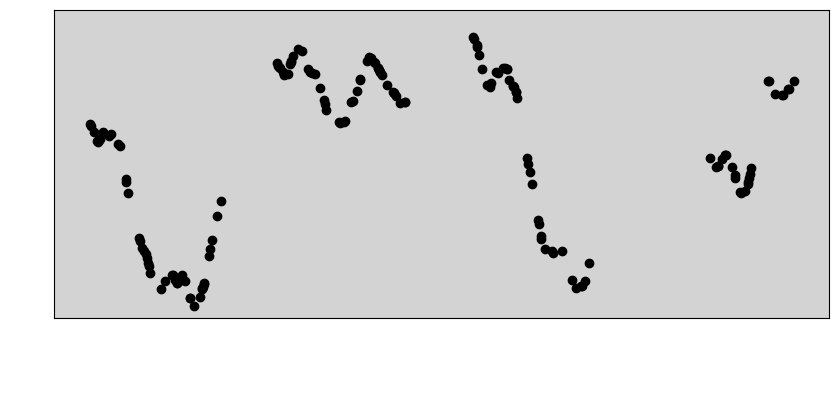

In [100]:
fig,ax = plt.subplots(figsize=(10,4))

plt.scatter(context['time']/365,context['light'],color='k',label='Observed data, '+r'$\vec{x}(\vec{t})$')
#plt.plot(target['time']/365,target['light'],color='k',linestyle='--',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)

#plt.plot(target['time']/365,mean,color='C1',zorder=0,label='Gaussian process, '+r'$f^{\ast}(\vec{t}^{\ast})$')
#plt.fill_between(target['time']/365,mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})


plt.ylabel('Magnitude, F',fontsize=25)
plt.xlabel('Time, t [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks([])
#plt.legend(fontsize=FS,loc='upper left',framealpha=1)
plt.ylim(-0.6,1.)
set_style()
#set_style(filename='GP_fit_example_no_GP')

In [95]:
grid = np.arange(context['time'].min(),context['time'].max())
spline = np.interp(grid,context['time'],context['light'])

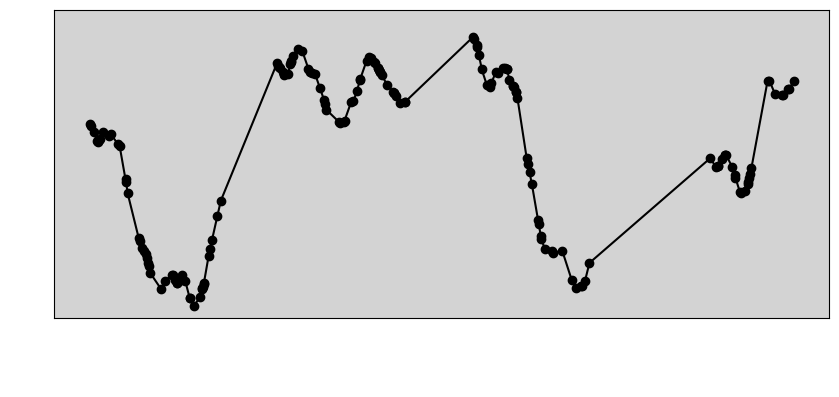

In [172]:
fig,ax = plt.subplots(figsize=(10,4))

plt.scatter(context['time']/365,context['light'],color='k',label='Observed data, '+r'$\vec{x}(\vec{t})$')
plt.plot(grid/365,spline,color='k',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)
#plt.plot(target['time']/365,target['light'],color='k',linestyle='--',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)

#plt.plot(target['time']/365,mean,color='C1',zorder=0,label='Gaussian process, '+r'$f^{\ast}(\vec{t}^{\ast})$')
#plt.fill_between(target['time']/365,mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})


plt.ylabel('Magnitude, F',fontsize=25)
plt.xlabel('Time, t [years]',fontsize=25)
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.legend(fontsize=FS,loc='upper left',framealpha=1)
plt.ylim(-0.6,1.)
set_style()
#set_style(filename='GP_fit_example_spline')

In [116]:
freq = np.fft.rfftfreq(len(grid))
spline_spec = np.abs(scipy.fft.rfft(spline,norm='ortho'))**2
spline_spec/=spline_spec[1]

In [121]:
true_labels

(0.0, 1, 600, 18)

In [119]:
true_spec = 1/((1+(2*np.pi*freq*true_labels[-2])**2)*(1+(2*np.pi*freq*true_labels[-1])**2))
true_spec/=true_spec[1]

/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_35447/1987443114.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(spline_spec))
/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_35447/1987443114.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(true_spec))


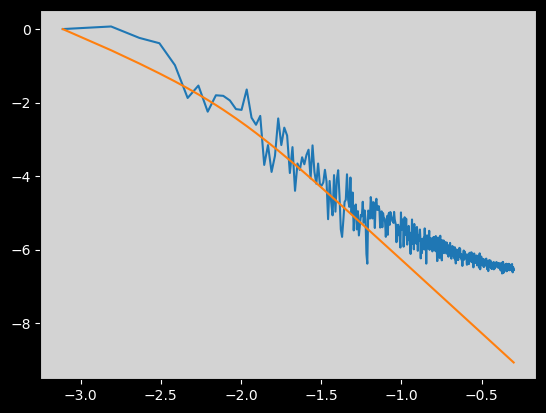

In [122]:
plt.plot(np.log10(freq),np.log10(spline_spec))
plt.plot(np.log10(freq),np.log10(true_spec))

In [154]:
result

array([ 0.34695693,  0.19509873, 85.47809008, 26.22577882])

In [161]:
pred_spec = 1/((1+(2*np.pi*freq*600)**2)*(1+(2*np.pi*freq*50)**2))
pred_spec/=pred_spec[1]

/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_35447/2048248793.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth')
/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_35447/2048248793.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction')


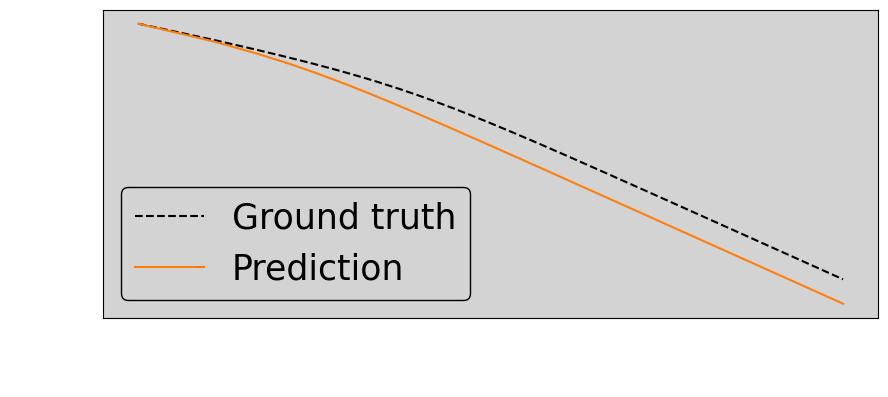

In [162]:
fig,ax = plt.subplots(figsize=(10,4))

plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth')
plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction')


plt.ylabel('log Power, S',fontsize=25)
plt.xlabel('log frequency, f [1/days]',fontsize=25)
#ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=25,loc='lower left',framealpha=1)
#plt.ylim(-0.6,1.)
set_style()
set_style(filename='Spec_fit_example_spline')

In [163]:
pred_spec = 1/((1+(2*np.pi*freq*600)**2)*(1+(2*np.pi*freq*result[-1])**2))
pred_spec/=pred_spec[1]

/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_35447/1344138658.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth')
/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_35447/1344138658.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction')


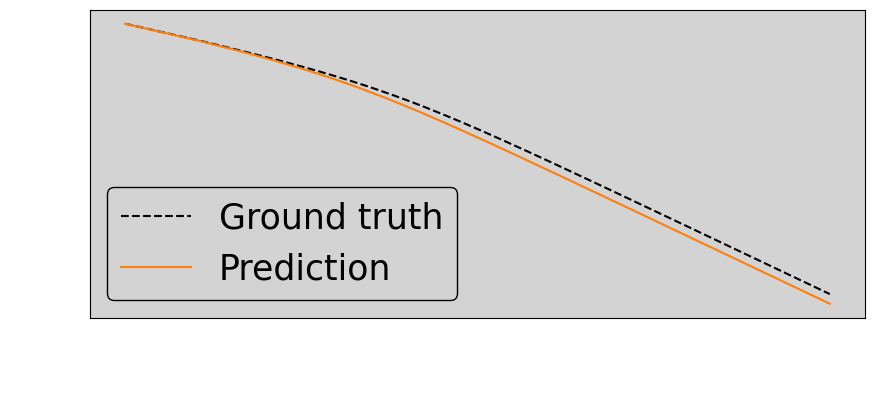

In [164]:
fig,ax = plt.subplots(figsize=(10,4))

plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth')
plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction')


plt.ylabel('log Power, S',fontsize=25)
plt.xlabel('log frequency, f [1/days]',fontsize=25)
#ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=25,loc='lower left',framealpha=1)
#plt.ylim(-0.6,1.)
set_style()
set_style(filename='Spec_fit_example_spline_ref')

In [130]:
pred_spec = 1/((1+(2*np.pi*freq*600)**2)*(1+(2*np.pi*freq*result[-1])**2))
pred_spec/=pred_spec[1]

/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_35447/2048248793.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth')
/var/folders/zv/64gdgpyn5rdf8f59mh13fk2h0000gn/T/ipykernel_35447/2048248793.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction')


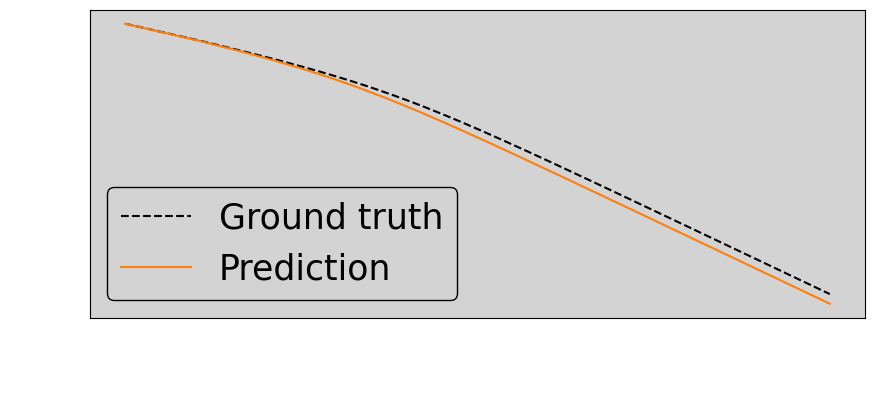

In [143]:
fig,ax = plt.subplots(figsize=(10,4))

plt.plot(np.log10(freq),np.log10(true_spec),color='k',linestyle='--',label='Ground truth')
plt.plot(np.log10(freq),np.log10(pred_spec),color='C1',label='Prediction')


plt.ylabel('log Power, S',fontsize=25)
plt.xlabel('log frequency, f [1/days]',fontsize=25)
#ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=25,loc='lower left',framealpha=1)
#plt.ylim(-0.6,1.)
set_style()
set_style(filename='Spec_fit_example_spline')

In [146]:
mean, var = RDRW.predict(target['time'].values, context['time'].values, context['light'].values, np.zeros_like(context['light'].values), *true_labels,return_cov_matrix=True)

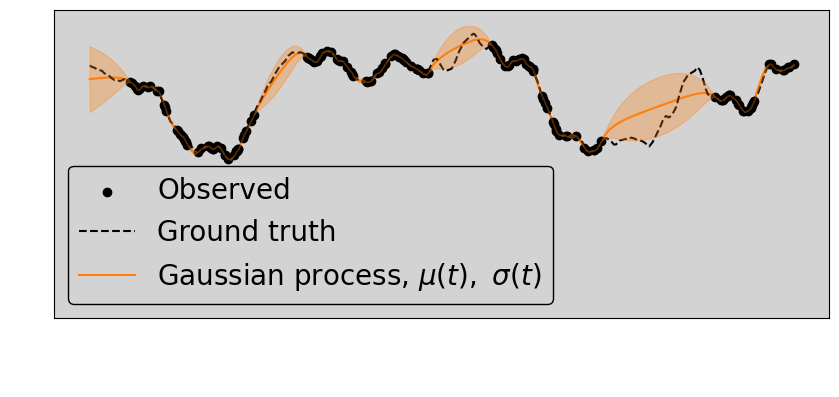

In [170]:
fig,ax = plt.subplots(figsize=(10,4))
mask = (target['time']<context['time'].max())
plt.scatter(context['time']/365,context['light'],color='k',label='Observed')
#plt.plot(grid/365,spline,color='k',linestyle='--',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)
plt.plot(target['time'][mask]/365,target['light'][mask],color='k',linestyle='--',label='Ground truth',zorder=1)


plt.plot(target['time'][mask]/365,mean[mask],color='C1',zorder=0,label='Gaussian process, '+r'$\mu(t), \ \sigma(t)$')
plt.fill_between(target['time'][mask]/365,mean[mask]+np.sqrt(np.diag(var))[mask],mean[mask]-np.sqrt(np.diag(var))[mask],alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})


plt.ylabel('Magnitude, F',fontsize=25)
plt.xlabel('Time, t [years]',fontsize=25)
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=20,loc='lower left',framealpha=1)
plt.ylim(-2.5,1.3)

set_style()
set_style(filename='GP_fit_example_interp')

In [127]:
result

array([ 0.34695693,  0.19509873, 85.47809008, 26.22577882])

In [61]:
gt_line

In [4]:
_ = simulate_context(5,0.,1,600,18,8)

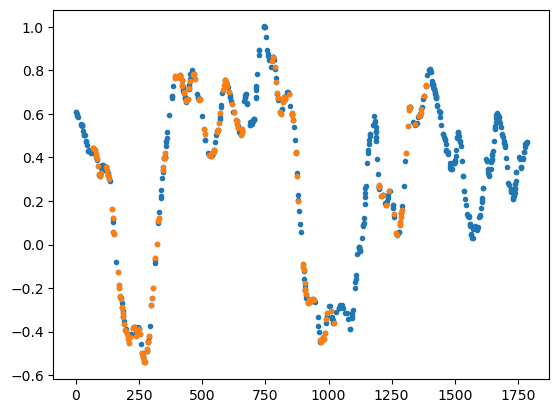

In [4]:
context,target,params_GT = simulate_context(5,0.,1,600,18,8)
plt.scatter(target['time'],target['light'],marker='.')
plt.scatter(context['time'],context['light'],marker='.')

In [5]:
from Modules.Gaussian_process.Utils import Optimizer


optimizer = Optimizer(context['time'].values, context['light'].values, np.zeros_like(context['light'].values),
                                  normalisation='day',report_learning=False)

result,_ = optimizer.optimize()

In [6]:
mean, var = RDRW.predict(target['time'].values, context['time'].values, context['light'].values, np.zeros_like(context['light'].values), *result,return_cov_matrix=True)

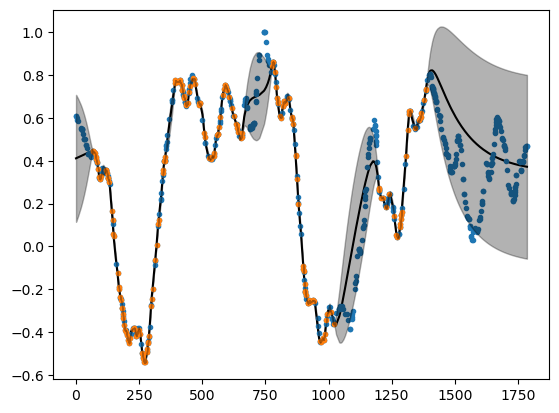

In [7]:
plt.scatter(*target[['time','light']].values.T,marker='.',color='C0')

plt.scatter(*context[['time','light']].values.T,marker='.',color='C1')

plt.plot(target['time'],mean,color='k',zorder=0)
plt.fill_between(target['time'],mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='k')

In [8]:
suggestions = optimizer._prepare_for_optimization()
suggestions

(array([ 0.24210774, -0.76992486,  0.03770714, -1.31229286]),
 array([-0.54197231,        -inf, -0.76229285,        -inf]),
 array([ 0.86170481,         inf,         inf, -0.76229287]))

In [12]:
Loss_RDRW = optimizer.compile_loss()

def labels_to_args(labels):
    Mean,Variance,Corr_time,Rev_time = labels
    Arguments = np.array([Mean,np.log10(Variance/(Corr_time+Rev_time)*365),np.log10(Corr_time/365),np.log10(Rev_time/365)])
    return Arguments


def loss(labels):
    Arguments = labels_to_args(labels)
    return Loss_RDRW(Arguments).item()

In [13]:
true_labels = (0.,1,600,18)
true_args = labels_to_args(true_labels)
#true_args = np.array([0,np.log10(1/(600+18)*365),np.log10(600/365),np.log10(18/365)])

In [10]:
logdesc_variance_array = np.linspace(-0.4,0,100)
logtau_arr = np.linspace(0.1,0.3,100)
losses = np.zeros((len(logdesc_variance_array),len(logtau_arr)))

for i,v in enumerate(tqdm(logdesc_variance_array)):
    for j,tau in enumerate(logtau_arr):
        losses[i,j] = Loss_RDRW([true_args[0],v,tau,true_args[-1]]).item()

100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


In [11]:
grad = jax.grad(Loss_RDRW)

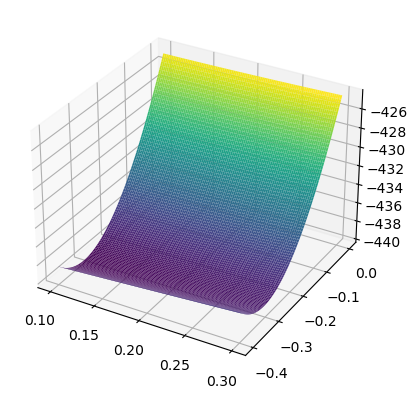

In [12]:
X, Y = np.meshgrid(logtau_arr,logdesc_variance_array)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, losses, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

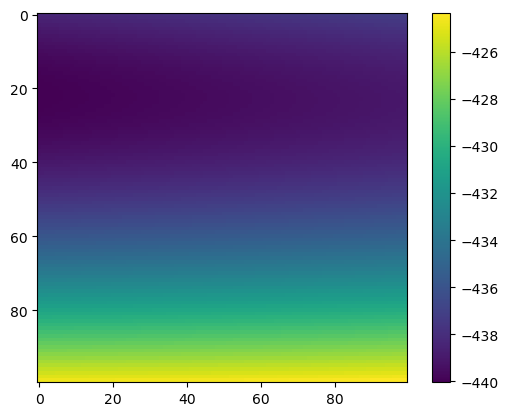

In [13]:
plt.imshow(losses)
plt.colorbar()

In [14]:
mean, var = RDRW.predict(target['time'].values, context['time'].values, context['light'].values, np.zeros_like(context['light'].values), *true_labels,return_cov_matrix=True)

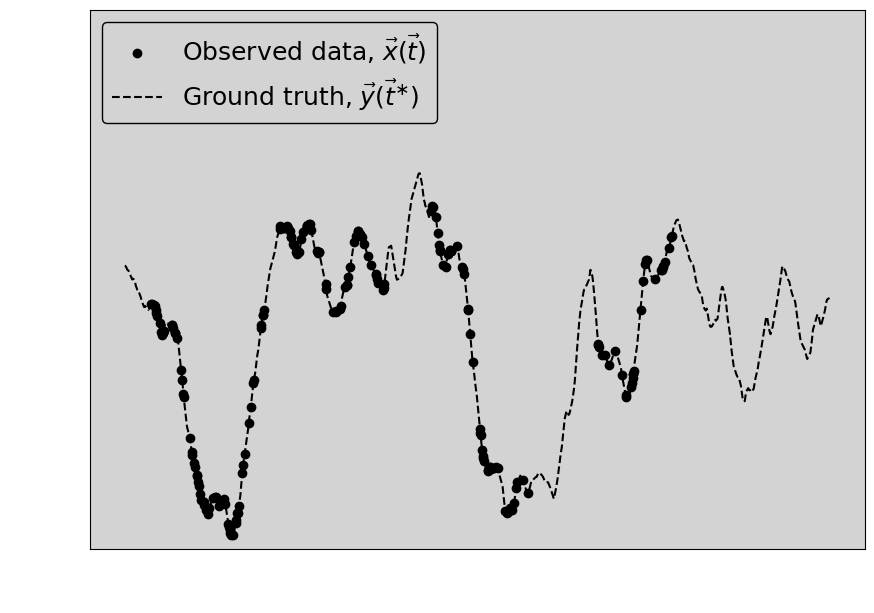

In [15]:
fig,ax = plt.subplots(figsize=(10,7))

plt.scatter(context['time']/365,context['light'],color='k',label='Observed data, '+r'$\vec{x}(\vec{t})$')
plt.plot(target['time']/365,target['light'],color='k',linestyle='--',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)

#plt.plot(target['time']/365,mean,color='C1',zorder=0,label='Gaussian process, '+r'$f^{\ast}(\vec{t}^{\ast})$')
#plt.fill_between(target['time']/365,mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})
plt.ylabel('Magnitude',fontsize=FS)
plt.xlabel('Time, [years]',fontsize=FS)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=FS,loc='upper left',framealpha=1)
plt.ylim(-0.6,1.7)
set_style()
#set_style(filename='GP_fit_example_no_GP')

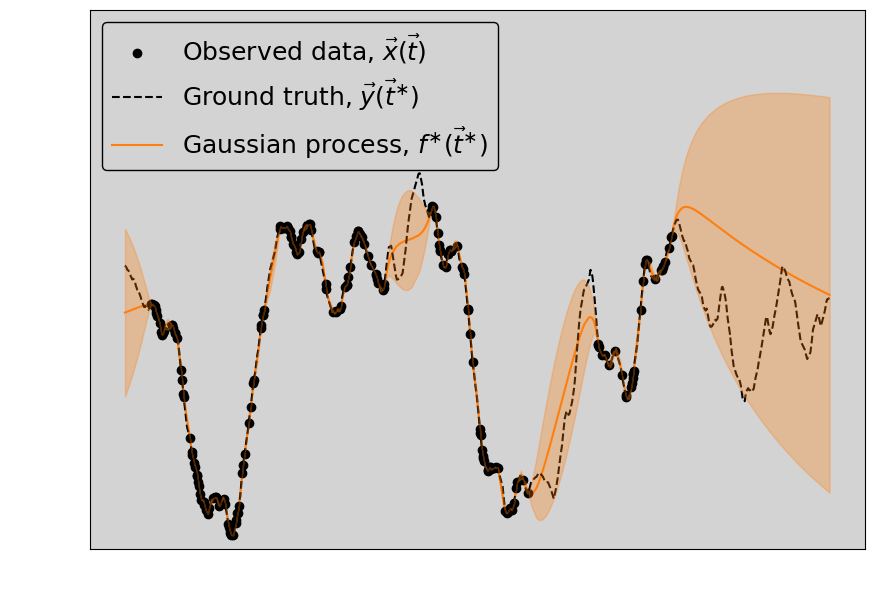

In [16]:
fig,ax = plt.subplots(figsize=(10,7))

plt.scatter(context['time']/365,context['light'],color='k',label='Observed data, '+r'$\vec{x}(\vec{t})$')
plt.plot(target['time']/365,target['light'],color='k',linestyle='--',label='Ground truth, '+r'$\vec{y}(\vec{t}^{\ast})$',zorder=1)

plt.plot(target['time']/365,mean,color='C1',zorder=0,label='Gaussian process, '+r'$f^{\ast}(\vec{t}^{\ast})$')
plt.fill_between(target['time']/365,mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})
plt.ylabel('Magnitude',fontsize=FS)
plt.xlabel('Time, [years]',fontsize=FS)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=FS,loc='upper left',framealpha=1)
plt.ylim(-0.6,1.7)
set_style()
#set_style(filename='GP_fit_example')

# GP interpolation for lensing

In [17]:
from Modules.datasets.Reverberating_Damped_Random_Walk import Masking
import scipy

from scipy import stats
from Modules.datasets.Reverberating_Damped_Random_Walk import Masking

def sample_time_stamps(Poisson_scale,Expected_duration, random_seed = 42):

    time_diff_sampler=scipy.stats.expon(scale=Poisson_scale)

    # Elementary Renewal theorem for Poisson process
    size = round(Expected_duration / Poisson_scale)

    # time steps between observations
    time_diffs=time_diff_sampler.rvs(size=size,random_state=random_seed)

    # time of observation
    time_array=np.append([0],np.cumsum(time_diffs))

    # timespan cutoff
    return  time_array

from Modules.Gaussian_process import RDRW,RDRW_optimization,Utils

target_Poisson_scale = 2.5
context_Poisson_scale = 5


log_corr_bounds=(1.8,3.4)
log_rev_bounds=(0.6,1.8)

def get_DRW_Loss(time_array,Light_curve,Light_curve_errs):

    @jax.jit
    def Loss_DRW(Arguments):

        Mean,Descaled_logVariance,log_Correlation_time = Arguments

        Correlation_time = jnp.power(10,log_Correlation_time)
        Variance=jnp.power(10,Descaled_logVariance)*Correlation_time
        #Variance = jnp.power(10, Descaled_logVariance)

        NLL= RDRW_optimization.NegLogLikelihood(time_array,Light_curve,Light_curve_errs,Mean,Variance,Correlation_time,1.,Curve_type='DRW',Normalised=True)

        return NLL

    return Loss_DRW

def optimize_DRW(time_array,Light_curve,Light_curve_errs):
    loss_DRW = get_DRW_Loss(time_array,Light_curve,Light_curve_errs)

    Descaled_Variance = Light_curve.var() / np.power(10,2.6)
    initial_guess = [Light_curve.mean(),jnp.log10(Descaled_Variance),2.6]

    bounds_DRW=scipy.optimize.Bounds(lb = np.array((Light_curve.min(),-np.inf,np.log10(np.diff(time_array).min()))),
                             ub = np.array((Light_curve.max(),np.inf, 3.4)), keep_feasible=True)


    grad = jax.grad(loss_DRW)
    Loss = lambda x: loss_DRW(x).item()
    Grad = lambda x: np.array(grad(x))

    res=scipy.optimize.minimize(Loss,initial_guess,method='TNC',jac=Grad,
                                    bounds=bounds_DRW)


    Mean,Descaled_logVariance,log_Correlation_time = res.x

    Correlation_time = jnp.power(10,log_Correlation_time)
    Variance=jnp.power(10,Descaled_logVariance)*Correlation_time


    label= np.array([Mean,Variance,Correlation_time])
    return label

def merged_curves(time_delay,magnification,context):

    time = jnp.append(context['time'].values,context['time'].values+time_delay)
    light = jnp.append(context['light_0'].values,context['light_1'].values-magnification)
    err = jnp.append(context['err'].values,context['err'].values)

    return time,light,err


def loss(lensing,labels):
    time_delay,magnification,mean,variance = lensing

    time,light,err = merged_curves(time_delay,magnification,context)

    return RDRW_optimization.NegLogLikelihood(time,light,err,mean,variance,*labels[2:])

<ErrorbarContainer object of 3 artists>

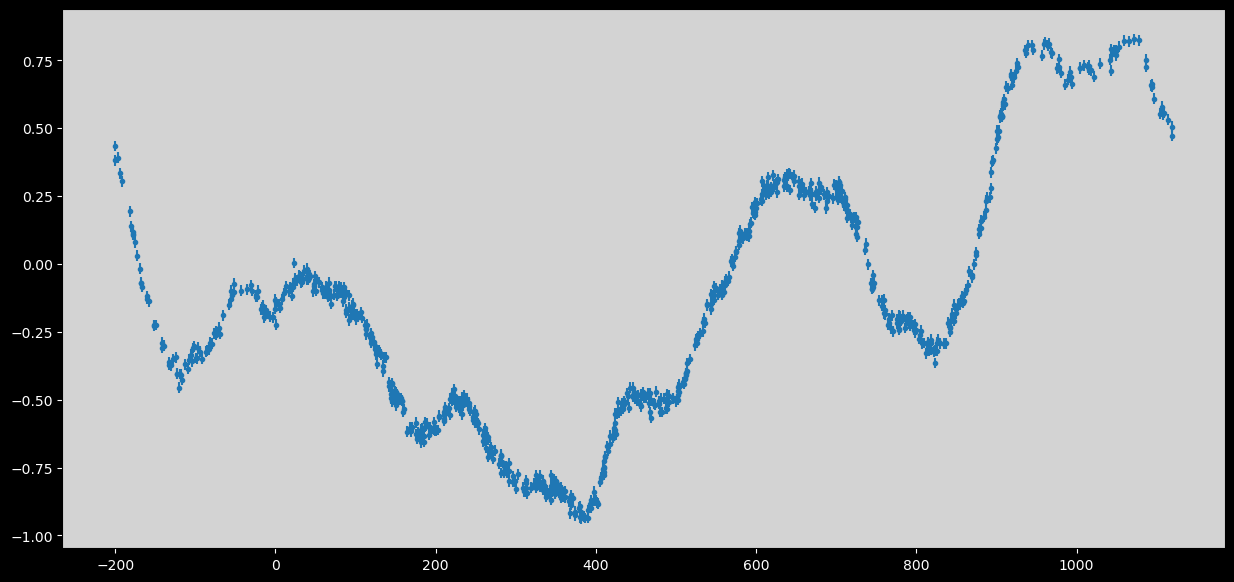

In [18]:
from Modules.Gaussian_process import RDRW,RDRW_optimization,Utils

magnification = 2
time_delay = -200

time_obs = sample_time_stamps(2.5, 3*365, 7)
time_gt=np.append(time_obs,time_obs+time_delay)

params_GT=np.array([0,1,1000.,30.,magnification,time_delay])

LC_sampler = RDRW.get_GP_sampler(time_gt, *params_GT[2:4], Curve_type='RDRW')
light_gt = LC_sampler(*params_GT[:2], random_seed=3)
# err = 0.05
err = 0.02
# 0
noise_rng = np.random.default_rng(seed=3)
noise = noise_rng.normal(0,err,size=light_gt.shape)

target = pd.DataFrame(np.array([time_gt,light_gt + noise,noise,err*np.ones_like(time_gt),np.arange(len(time_gt))<len(time_obs)]).T,
                       columns=['time','light','noise','err','curve_index'])

fig = plt.subplots(figsize=(15,7))
plt.errorbar(target['time'],target['light'],target['err'],fmt='.')

In [19]:
#18
# 3
rng = np.random.default_rng(seed=6)
border_gap_sampler = Masking.get_truncnorm_sampler(72,25,0,np.inf,rng)

def border_gaps_masks(time_arrays):
    start_gap_masks, end_gap_masks = Masking.sample_border_masks(time_arrays,border_gap_sampler)
    return start_gap_masks, end_gap_masks

gaps_lengths = border_gap_sampler(2 * (int(time_obs.max()/365)+1)).reshape(2, -1)

gaps_borders = np.array([gaps_lengths[0] + np.arange(gaps_lengths.shape[1])*365,
                         np.arange(1,gaps_lengths.shape[1]+1)*365 - gaps_lengths[1]]).T

no_gap_mask = np.array([ (borders[0]<time_obs) & (time_obs<borders[1]) for borders in gaps_borders]).sum(0).astype(bool)

subsampling_mask = Masking.Poisson_process_subsampling_mask(1/target_Poisson_scale,1/context_Poisson_scale,time_obs.shape,rng)

In [20]:
context = pd.DataFrame(np.array([time_obs,target['light'][target['curve_index'].astype(bool)],
                                 target['light'][~target['curve_index'].astype(bool)]+params_GT[-2],target['err'][target['curve_index'].astype(bool)]]).T,
                       columns=['time','light_0','light_1','err'])

context = context[no_gap_mask & subsampling_mask]
min_time =context['time'].iloc[0]
context['time']-=context['time'].iloc[0]
context = context.reset_index(drop=True)

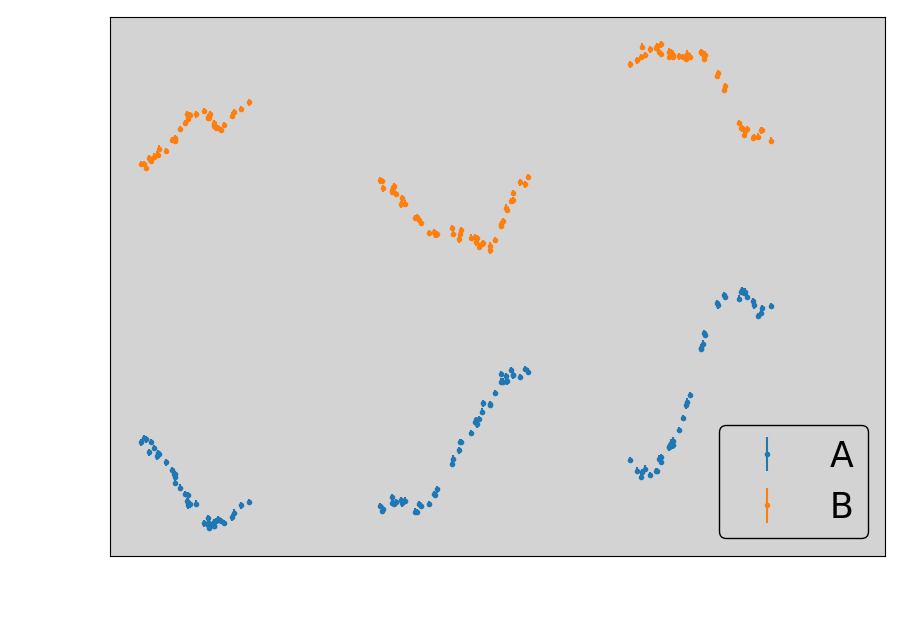

In [21]:
fig,ax = plt.subplots(figsize=(10,7))

ax.errorbar(context['time']/365,context['light_0'],context['err'],fmt='.',label='A')
ax.errorbar(context['time']/365,context['light_1'],context['err'],fmt='.',label='B')

#plt.plot(target['time']/365,mean,color='C1',zorder=0,label='Gaussian process, '+r'$f^{\ast}(\vec{t}^{\ast})$')
#plt.fill_between(target['time']/365,mean+np.sqrt(np.diag(var)),mean-np.sqrt(np.diag(var)),alpha=0.3,color='C1')
#\sim \mathcal{N}(\vec{\mu}^{\ast},\mathbf{\Sigma}^{\ast})
plt.ylabel('Magnitude',fontsize=25)
plt.xlabel('Time, [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=25,framealpha=1,loc='lower right')
plt.xticks([0,1,2,3])
set_style()
#set_style(filename='GP_lensed_example')

In [22]:
from Modules.Gaussian_process.Utils import Optimizer
optimizer_RDRW_0 = Optimizer(context['time'].values, context['light_0'].values, context['err'].values,
                                        *params_GT[2:4],
                                        normalisation='day',report_learning=False)

optimizer_RDRW_1 = Optimizer(context['time'].values, context['light_1'].values, context['err'].values,
                                        *params_GT[2:4],
                                         normalisation='day',report_learning=False)

RDRW_0,_ = optimizer_RDRW_0.optimize()
RDRW_1,_ = optimizer_RDRW_1.optimize()

res_DRW_0 = optimize_DRW(context['time'].values,context['light_0'].values,context['err'].values)
res_DRW_1 = optimize_DRW(context['time'].values,context['light_1'].values,context['err'].values)

In [23]:
res_DRW_0

array([1.70975965e-01, 2.27286006e-01, 1.08485407e+03])

In [24]:
res_DRW_1

array([1.70235012e+00, 7.82429750e-02, 5.38374750e+02])

In [25]:
query_times = np.append(np.arange(context['time'].min(),context['time'].max(),1),context['time'].values)

In [26]:
mean_true_0,variance_true_0 = RDRW.predict(query_times,context['time'].values,context['light_0'].values,
                                 context['err'].values,*params_GT[:-2],return_cov_matrix=True)

mean_true_1,variance_true_1 = RDRW.predict(query_times,context['time'].values,context['light_1'].values,
                                 context['err'].values,*params_GT[:-2],return_cov_matrix=True)

mean_true_temp_0,variance_true_temp_0 = RDRW.predict(query_times,context['time'].values,context['light_0'].values,
                                 context['err'].values,*RDRW_0,return_cov_matrix=True)

mean_true_temp_1,variance_true_temp_1 = RDRW.predict(query_times,context['time'].values,context['light_1'].values,
                                 context['err'].values,*RDRW_1,return_cov_matrix=True)

mean_DRW_0,variance_DRW_0 = RDRW.predict(query_times,context['time'].values,context['light_0'].values,
                                 context['err'].values,*res_DRW_0,Reverberation_time=0.,return_cov_matrix=True)

mean_DRW_1,variance_DRW_1 = RDRW.predict(query_times,context['time'].values,context['light_1'].values,
                                 context['err'].values,*res_DRW_1,Reverberation_time=0.,return_cov_matrix=True)

In [27]:
def plot_GP(mean,variance,ax,color,len,labels=[None,None],linewidth=2,**kwargs):
    line =ax.plot(query_times[:len]/365,mean[:len],color=color,label=labels[0],linewidth=linewidth,**kwargs)
    contour = ax.fill_between(query_times[:len]/365,mean[:len]+np.sqrt(np.diag(variance))[:len],mean[:len]-np.sqrt(np.diag(variance))[:len],
                   color=color,alpha=0.2,label=labels[1],**kwargs)
    return line,contour

In [28]:
length = len(query_times) - len(context['time'])

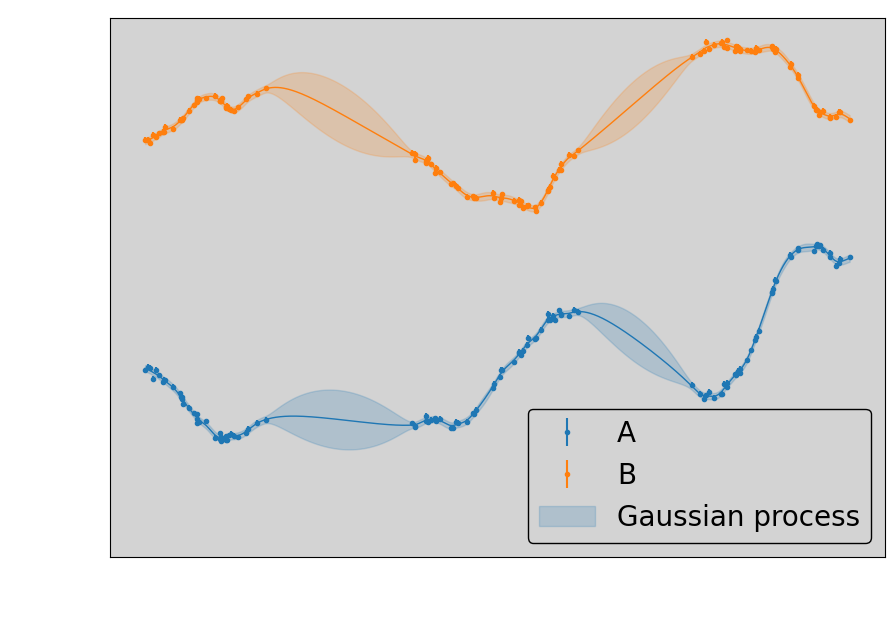

In [29]:
fig,ax = plt.subplots(figsize=(10,7))

q0=ax.errorbar(context['time']/365,context['light_0'],context['err'],fmt='.',label='A')
q1=ax.errorbar(context['time']/365,context['light_1'],context['err'],fmt='.',label='B')


line,contour = plot_GP(mean_true_0,variance_true_0,ax,color='C0',len=length,labels=['Gaussian process','Gaussian process'],linewidth=1,zorder=0)
plot_GP(mean_true_1,variance_true_1,ax,color='C1',len=length,linewidth=1,zorder=0)


plt.ylabel('Magnitude',fontsize=25)
plt.xlabel('Time, [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend([q0,q1,contour],['A','B','Gaussian process'],fontsize=20,framealpha=1,loc='lower right')
plt.xticks([0,1,2])
plt.ylim(-1.5,2.5)
set_style()
#set_style(filename='GP_lensed_example')

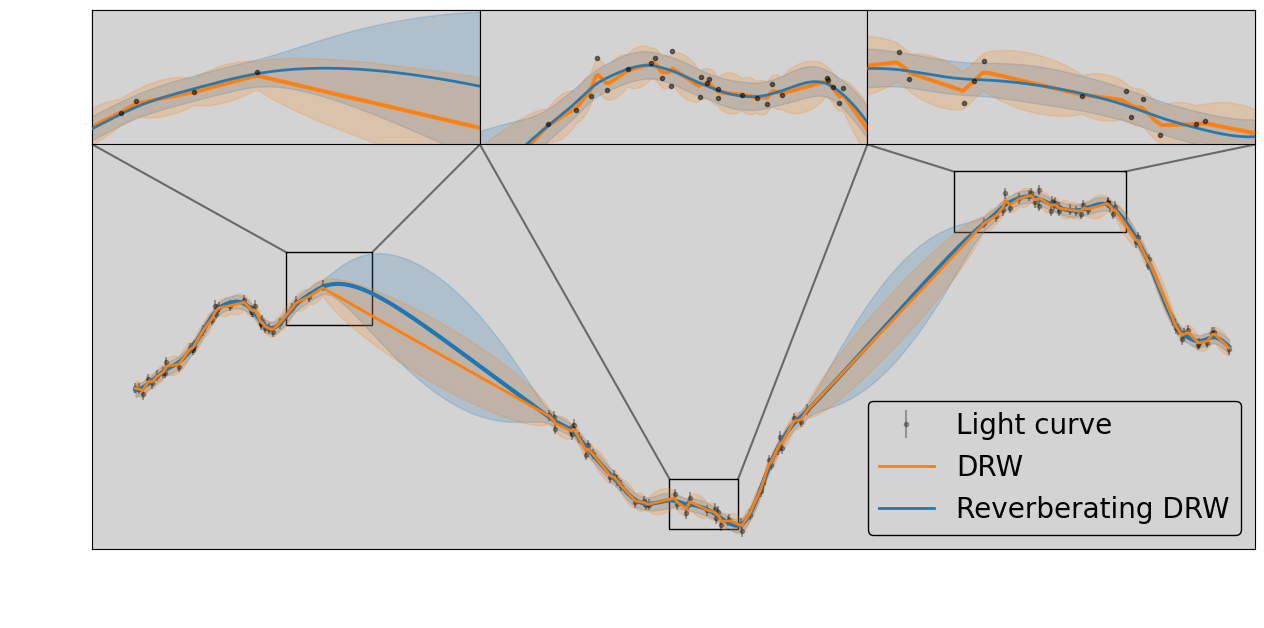

In [663]:
fig,ax = plt.subplots(figsize=(15,7))


def plot_all(ax2):
    ax2.errorbar(context['time']/365,context['light_1'],fmt='.',color='k',alpha=0.5,zorder=3)
    plot_GP(mean_true_1,variance_true_1,ax2,color='C0',len=length,linewidth=1,zorder=0)
    plot_GP(mean_DRW_1,variance_DRW_1,ax2,color='C1',len=length,linewidth=1,zorder=0)
    ax2.plot(query_times[:length]/365,mean_true_1[:length],color='C0',linewidth=2,zorder=3,alpha=0.9)
    ax2.plot(query_times[:length]/365,mean_DRW_1[:length],color='C1',linewidth=3,zorder=2,alpha=0.9)

#q0=ax.errorbar(context['time']/365,context['light_0'],context['err'],fmt='.',label='Light curve',color='k',alpha=0.5)
q1=ax.errorbar(context['time']/365,context['light_1'],context['err'],fmt='.',color='k',alpha=0.3)


#line_RDRW,_ = plot_GP(mean_true_0,variance_true_0,ax,color='C0',len=length,labels=[None,None],linewidth=1,zorder=0)
plot_GP(mean_true_1,variance_true_1,ax,color='C0',len=length,linewidth=1,zorder=1)
line =ax.plot(query_times[:length]/365,mean_true_1[:length],color='C0',linewidth=3,zorder=3)

#line_DRW,_ = plot_GP(mean_DRW_0,variance_DRW_0,ax,color='C1',len=length,labels=[None,None],linewidth=1,zorder=0)
plot_GP(mean_DRW_1,variance_DRW_1,ax,color='C1',len=length,linewidth=1,zorder=1)
line_RDRW =ax.plot(query_times[:length]/365,mean_true_1[:length],color='C0',linewidth=2,zorder=3)
line_DRW =ax.plot(query_times[:length]/365,mean_DRW_1[:length],color='C1',linewidth=2,zorder=3)

ax2 = ax.inset_axes([.0, .75, .333333, .25],frame_on=True)
ax3 = ax.inset_axes([.333333, .75, .333333, .25],frame_on=True)
ax4 = ax.inset_axes([.666666, .75, .333333, .25],frame_on=True)

for temp in [ax2,ax3,ax4]:
    plot_all(temp)
    temp.set_xticks([])
    temp.set_yticks([])

xlims = (0.35,0.55)
ylims = (1.83,2.1)
ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)
rect = mpl.patches.Rectangle((xlims[0],ylims[0]),xlims[1]-xlims[0],ylims[1]-ylims[0],alpha=1,edgecolor='k',facecolor='lightgray',zorder=0)
ax.add_patch(rect)


xlims = (1.9,2.3)
ylims = (2.175,2.4)
ax3.set_xlim(*xlims)
ax3.set_ylim(*ylims)
rect = mpl.patches.Rectangle((xlims[0],ylims[0]),xlims[1]-xlims[0],ylims[1]-ylims[0],alpha=1,edgecolor='k',facecolor='lightgray',zorder=0)
ax.add_patch(rect)

xlims = (1.24,1.4)
ylims = (1.075,1.26)
ax4.set_xlim(*xlims)
ax4.set_ylim(*ylims)
rect = mpl.patches.Rectangle((xlims[0],ylims[0]),xlims[1]-xlims[0],ylims[1]-ylims[0],alpha=1,edgecolor='k',facecolor='lightgray',zorder=0)
ax.add_patch(rect)


ax.plot([0.35,-0.1],[2.1,2.5],color='k',alpha=0.5)
ax.plot([0.55,-0.1+2.7*.333333],[2.1,2.5],color='k',alpha=0.5)


ax.plot([1.9,-0.1+2.7*.666666],[2.4,2.5],color='k',alpha=0.5)
ax.plot([2.3,-0.1+2.7],[2.4,2.5],color='k',alpha=0.5)

ax.plot([1.24,-0.1+2.7*.333333],[1.26,2.5],color='k',alpha=0.5)
ax.plot([1.4,-0.1+2.7*.666666],[1.26,2.5],color='k',alpha=0.5)


plt.ylabel('Magnitude',fontsize=25)
plt.xlabel('Time, [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend([q1,line_DRW[0],line_RDRW[0]],['Light curve','DRW','Reverberating DRW'],fontsize=20,framealpha=1,loc='lower right')
plt.xticks([0,1,2])
plt.yticks([1,1.5,2,2.5])
plt.xlim(-0.1,2.6)
plt.ylim(1,3)
set_style()
#set_style(filename='GP_fit_RDRW_vs_DRW_no_annot')
#set_style(filename='GP_fit_RDRW_vs_DRW_annot')

In [40]:
def plot_GP(mean,variance,ax,color,len,labels=[None,None],linewidth=2,time_shift = 0,**kwargs):
    line =ax.plot((query_times[:len]+time_shift)/365,mean[:len],color=color,label=labels[0],linewidth=linewidth,**kwargs)
    contour = ax.fill_between((query_times[:len]+time_shift)/365,mean[:len]+np.sqrt(np.diag(variance))[:len],mean[:len]-np.sqrt(np.diag(variance))[:len],
                   color=color,alpha=0.2,label=labels[1],**kwargs)
    return line,contour

77.00046276557846

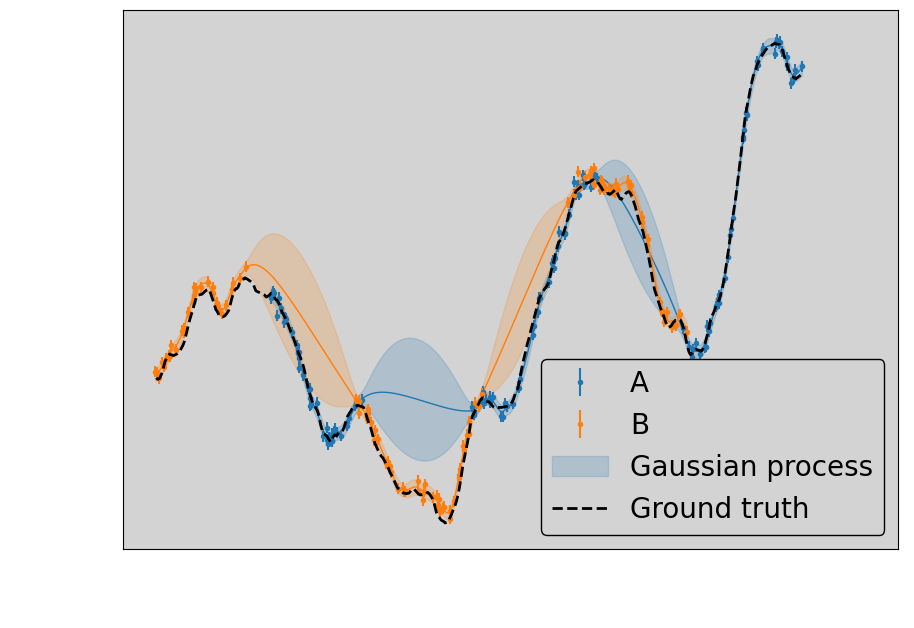

In [30]:
lensing_loss = jax.jit(lambda x: loss(x,RDRW_0))
grad = jax.grad(lensing_loss)
lensing_grad = lambda x: np.array(grad(x))

lensing_true_temp =scipy.optimize.minimize(lensing_loss,[time_delay,magnification,*RDRW_0[:2]],jac = lensing_grad,method='TNC')
lensing_true_temp.x

array([-2.00730446e+02,  1.99054123e+00,  4.57070607e-02,  8.22055755e-01])

In [31]:
lensing_loss = jax.jit(lambda x: loss(x,[0,0,1084,0]))
grad = jax.grad(lensing_loss)
lensing_grad = lambda x: np.array(grad(x))

lensing_DRW =scipy.optimize.minimize(lensing_loss,[time_delay,magnification,*res_DRW_0[:2]],jac = lensing_grad,method='Nelder-Mead')
lensing_DRW.x

/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/scipy/optimize/_minimize.py:550: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


array([-2.02724250e+02,  1.99866277e+00,  4.03664570e-02,  1.80781164e-01])

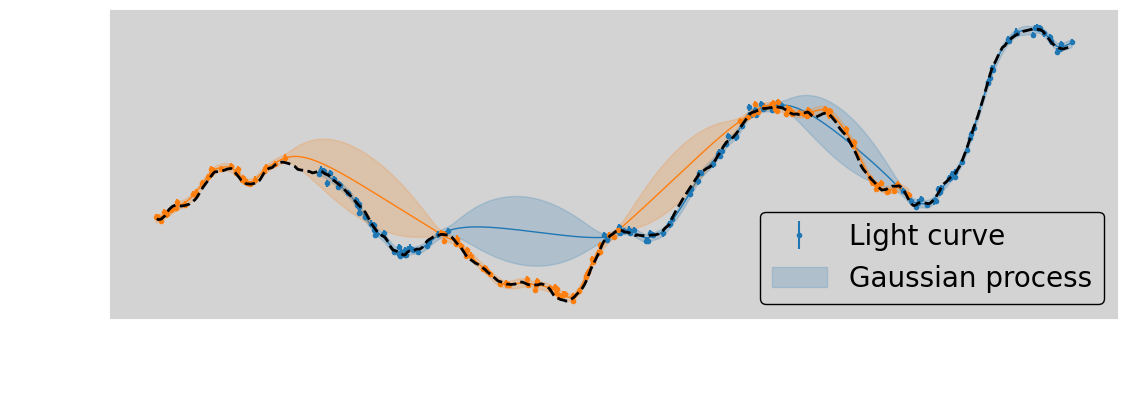

In [62]:
fig,ax = plt.subplots(figsize=(13,4))



q0=ax.errorbar(context['time']/365,context['light_0'],context['err'],fmt='.',label='A')
q1=ax.errorbar((context['time']+lensing_true_temp.x[0])/365,context['light_1']-lensing_true_temp.x[1],context['err'],fmt='.',label='B')


line,contour = plot_GP(mean_true_0,variance_true_0,ax,color='C0',len=length,labels=['Gaussian process','Gaussian process'],linewidth=1,zorder=0)
plot_GP(mean_true_1-lensing_true_temp.x[1],variance_true_1,ax,color='C1',len=length,linewidth=1,zorder=0,time_shift=lensing_true_temp.x[0])

q = np.argsort(target['time'])

mask_target = (target['time'][q]-min_time > -200) & (target['time'][q]-min_time < context['time'].max())
gt_line = ax.plot((target['time'][q][mask_target]-min_time)/365,(target['light']-target['noise'])[q][mask_target],color='k',linestyle='--',zorder = 6,linewidth = 2)

plt.ylabel('Magnitude',fontsize=25)
plt.xlabel('Time, [years]',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend([q0,contour],['Light curve','Gaussian process'],fontsize=20,framealpha=1,loc='lower right')
plt.xticks([0,1,2])
#plt.ylim(-1.5,2.5)
set_style()
#set_style(filename='GP_delensed_example_wide')

In [603]:
res_DRW_0

array([1.70975965e-01, 2.27286006e-01, 1.08485407e+03])

In [50]:
from tqdm import tqdm
time_shifsts_array= np.arange(-600,600)
#loss_shifts_true = np.array([loss([shift,*lensing_true.x[1:]],params_GT[:-2]) for shift in time_shifsts_array])
loss_shifts_true_temp = np.array([loss([shift,*lensing_true_temp.x[1:]],RDRW_0) for shift in tqdm(time_shifsts_array)])
loss_shifts_DRW = np.array([loss([shift,*lensing_DRW.x[1:]],[0,0,538,0]) for shift in tqdm(time_shifsts_array)])

100%|██████████| 1200/1200 [00:03<00:00, 318.53it/s]


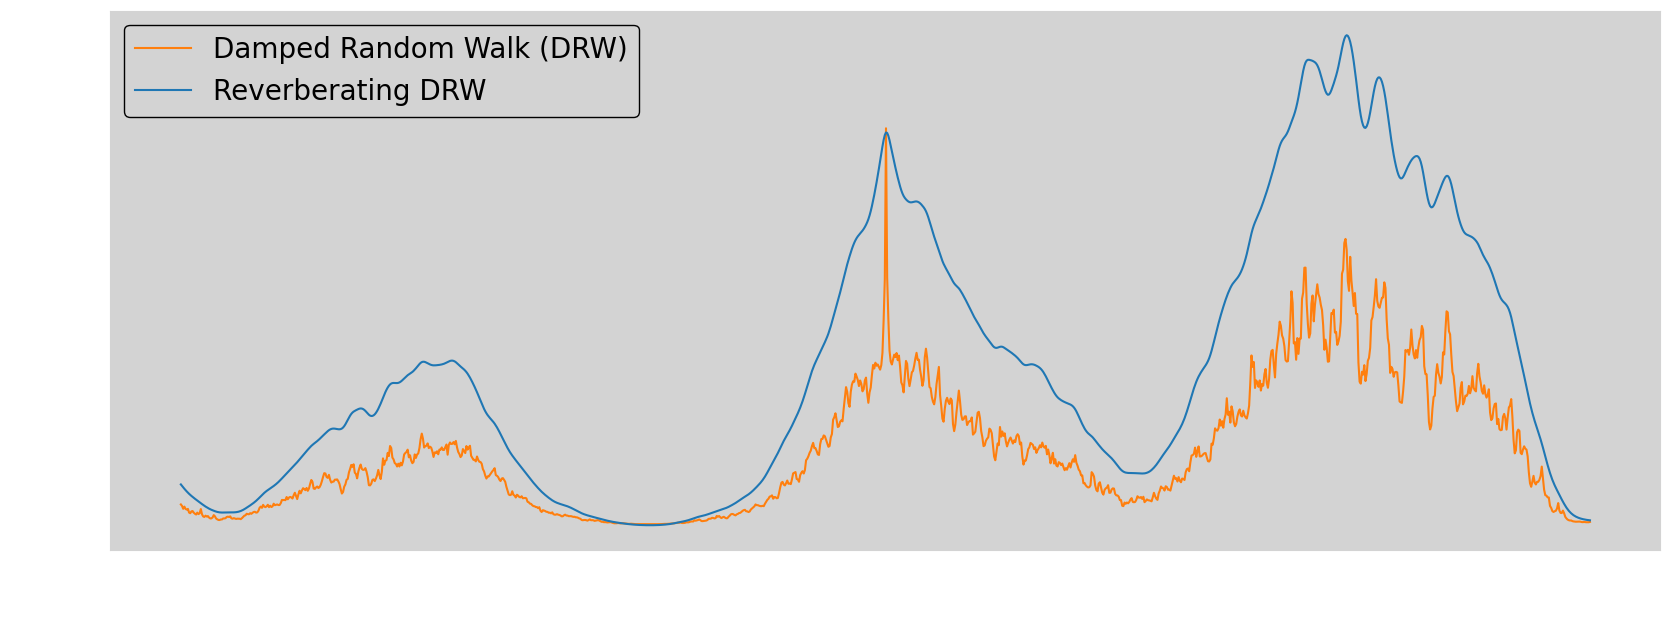

In [51]:
fig,ax = plt.subplots(figsize=(20,7))

ax.plot(time_shifsts_array,loss_shifts_DRW,label='Damped Random Walk (DRW)',color='C1')
ax.plot(time_shifsts_array,loss_shifts_true_temp,label='Reverberating DRW',color='C0')



ax.legend(fontsize=20,framealpha=1,loc='upper left')
ax.set_ylabel('Loss, '+r'$-log p(\Delta t_{12} \ | \Sigma )$',fontsize=20)
ax.set_xlabel('Lensing time delay ' +r'$ \Delta t_{12}$'+', [days]',fontsize=20)
#ax.set_xticks(np.arange(5)*365,np.arange(5))

ax.tick_params(axis='both', which='major', labelsize=12)
set_style()
#set_style('RDRW_lensing_time_delay')

In [52]:
time_shifsts_array_close= np.linspace(-210,-192.5,500)
#loss_shifts_true_close = np.array([loss([shift,*lensing_true.x[1:]],params_GT[:-2]) for shift in time_shifsts_array_close])
loss_shifts_true_temp_close = np.array([loss([shift,*lensing_true_temp.x[1:]],RDRW_0) for shift in time_shifsts_array_close])
loss_shifts_DRW_close = np.array([loss([shift,*lensing_DRW.x[1:]],[0,0,538,0]) for shift in time_shifsts_array_close])

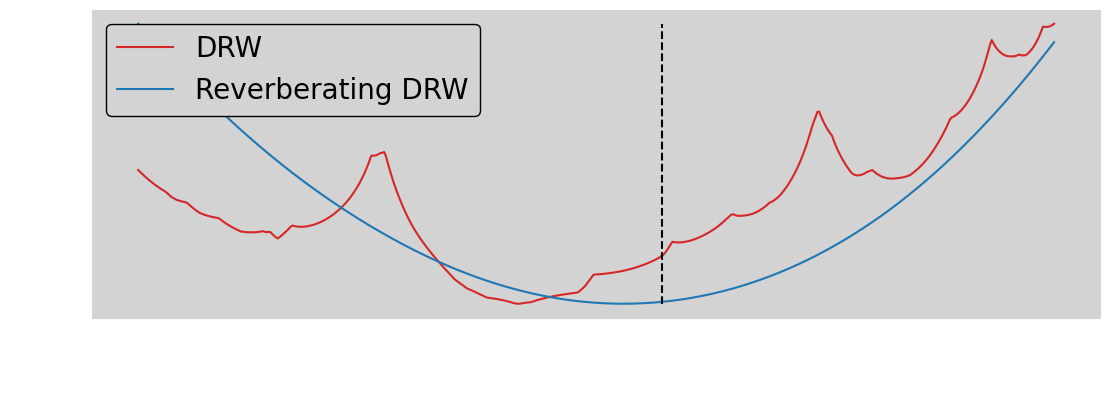

In [72]:
fig,ax = plt.subplots(figsize=(13,4))

normalize = lambda x: (x-x.min())/(x.max()-x.min())
#normalize = lambda x: x

ax.plot(time_shifsts_array_close,normalize(loss_shifts_DRW_close),label='DRW',color='C3')
ax.plot(time_shifsts_array_close,normalize(loss_shifts_true_temp_close),label='Reverberating DRW',color='C0')
gt_line=ax.vlines(-200,0,1,color='k',linestyle='--')


ax.legend(fontsize=20,framealpha=1,loc='upper left')
ax.set_ylabel('Loss',fontsize=25)
ax.set_xlabel('Lensing time delay ' +r'$ \Delta t_{12}$'+', [days]',fontsize=25)
#ax.set_xticks(np.arange(5)*365,np.arange(5))

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks([-210,-205,-200,-195])
set_style()
#set_style('RDRW_lensing_time_delay_close')

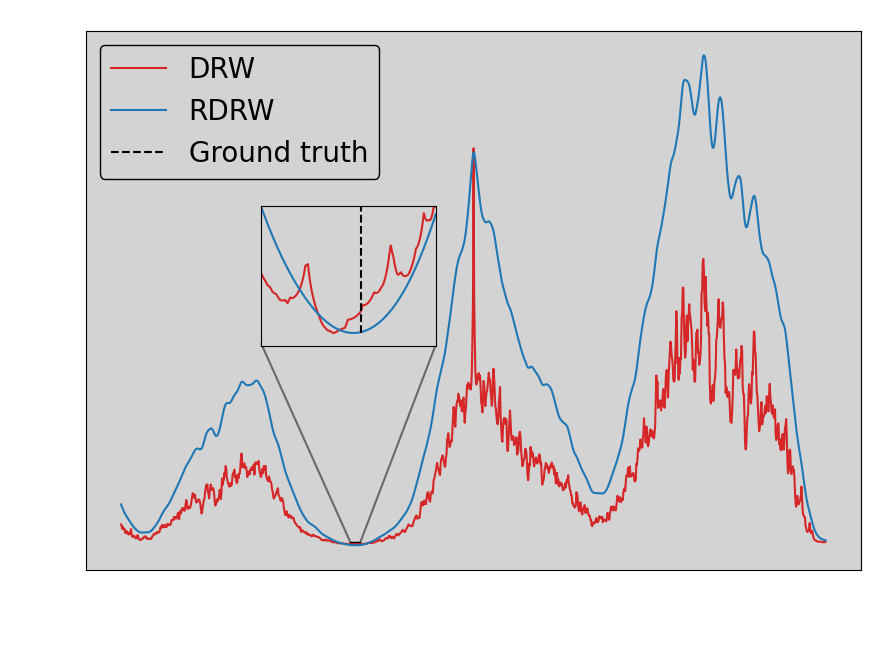

In [115]:
fig,ax = plt.subplots(figsize=(10,7))

line_DRW = ax.plot(time_shifsts_array,loss_shifts_DRW,label='DRW',color='C3')
line_RDRW = ax.plot(time_shifsts_array,loss_shifts_true_temp,label='Reverberating DRW',color='C0')

ax2 = plt.axes([.3, .43, .175, .2],frame_on=True)
ax2.set_xlim(-210,-192.5)
ax2.set_ylim(-0.1,1.)
ax2.set_xticks([])
ax2.set_yticks([])

normalize = lambda x: (x-x.min())/(x.max()-x.min())

ax2.plot(time_shifsts_array_close,normalize(loss_shifts_DRW_close),label='Damped Random Walk (DRW)',color='C3')
ax2.plot(time_shifsts_array_close,normalize(loss_shifts_true_temp_close),label='Reverberating DRW',color='C0')
gt_line=ax2.vlines(-200,0,1,color='k',linestyle='--')

#ax.indicate_inset_zoom(ax2,edgecolor='k')

rect = mpl.patches.Rectangle((-210,-270),-192.5+210,-320+250,alpha=1,edgecolor='k',facecolor='lightgray',zorder=0)
ax.add_patch(rect)


ax.plot([-210,-361],[-270,13500],color='k',alpha=0.5)
ax.plot([-192.5,-64],[-270,13500],color='k',alpha=0.5)

ax.legend([line_DRW[0],line_RDRW[0],gt_line],['DRW','RDRW','Ground truth'],fontsize=20,framealpha=1,loc='upper left')
#ax.set_ylabel('Loss, '+r'$-log p(\Delta t \ | \ \vec{x}_A, \vec{x}_B )$',fontsize=25)
ax.set_ylabel('Loss',fontsize=25)

ax.set_xlabel('Lensing time delay ' +r'$ \Delta t$'+', [days]',fontsize=25)
#ax.set_xticks(np.arange(5)*365,np.arange(5))

ax.tick_params(axis='both', which='major', labelsize=15)

from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)

set_style()
plt.text(0.0, 1.01, '1e+3', fontsize=15, transform = ax.transAxes,color='white')
ax.set_yticklabels((ax.get_yticks()//1000).astype(int))
#ax.set_yticklabels(np.arange(0,40,5))
#set_style('RDRW_lensing_time_delay')

In [32]:
time_delays = np.linspace(-210,-195,500)

In [33]:
lensing_loss = jax.jit(lambda x: loss(x,RDRW_0))
grad = jax.grad(lensing_loss)
hess = jax.jacfwd(jax.jacrev(lensing_loss))
lensing_grad = lambda x: np.array(grad(x))

In [34]:
nlls_RDRW = np.array([lensing_loss([shift,*lensing_true_temp.x[1:]]) for shift in tqdm(time_delays)])
nlls_RDRW -= nlls_RDRW.min()

100%|██████████| 500/500 [00:10<00:00, 49.27it/s]


In [35]:
lensing_loss = jax.jit(lambda x: loss(x,[0,0,538,0]))
grad = jax.grad(lensing_loss)
hess = jax.jacfwd(jax.jacrev(lensing_loss))
lensing_grad = lambda x: np.array(grad(x))

In [36]:
nlls_DRW = np.array([lensing_loss([shift,*lensing_DRW.x[1:]]) for shift in tqdm(time_delays)])
nlls_DRW -= nlls_DRW.min()

100%|██████████| 500/500 [00:11<00:00, 43.87it/s] 


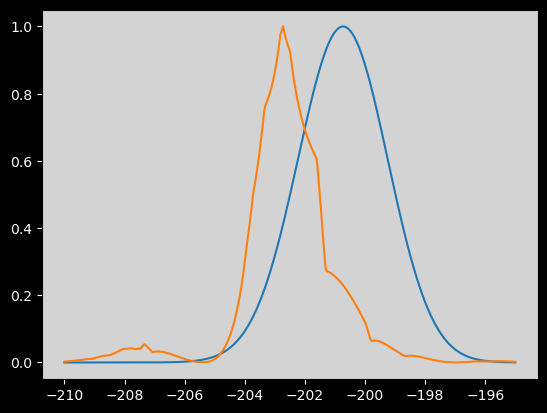

In [37]:
plt.plot(time_delays,np.exp(-nlls_RDRW))
plt.plot(time_delays,np.exp(-nlls_DRW))

In [38]:
H_0_samples = 74.03*(-200)/time_delays

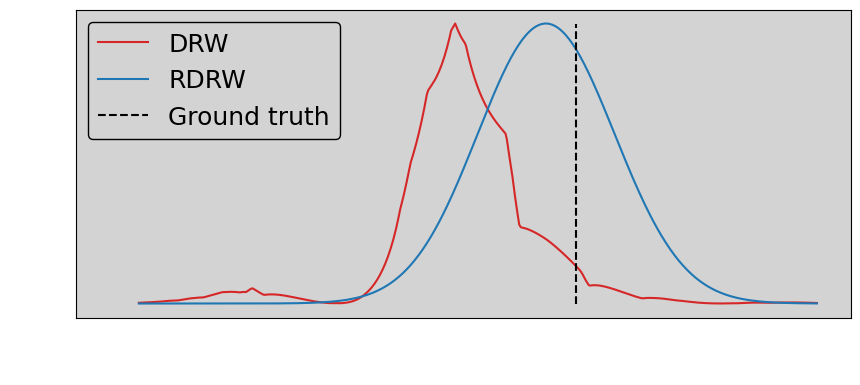

In [39]:
fig,ax = plt.subplots(figsize=(10,4))

#plt.plot(H_0_samples,np.exp(-nlls_RDRW)/(np.exp(-nlls_RDRW)[:-1]*np.diff(H_0_samples)).sum())
plt.plot(H_0_samples,np.exp(-nlls_DRW),color='C3',label='DRW')
plt.plot(H_0_samples,np.exp(-nlls_RDRW),label='RDRW')
plt.vlines(74,0,1,color='k',linestyle='--',label='Ground truth')

plt.xlabel('Hubble rate, '+r'$H_0$',fontsize=FS)
ax.set_xticks([70,72,74,76])
ax.set_yticks([0,0.5,1])
ax.tick_params(axis='both', which='major', labelsize=12)

plt.ylabel('Likelihood',fontsize=FS)
ax.legend(fontsize=FS,framealpha=1,loc='upper left')
set_style()
#set_style('H_rate_improvement')

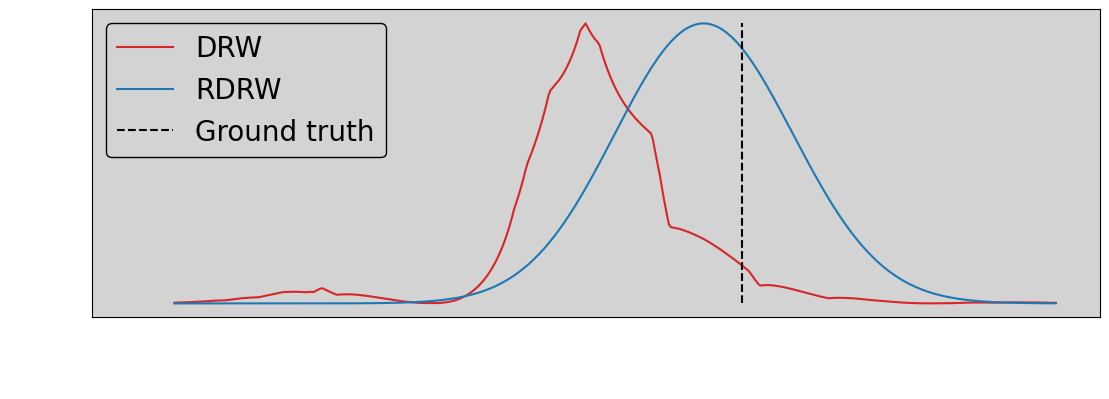

In [123]:
fig,ax = plt.subplots(figsize=(13,4))

#plt.plot(H_0_samples,np.exp(-nlls_RDRW)/(np.exp(-nlls_RDRW)[:-1]*np.diff(H_0_samples)).sum())
plt.plot(H_0_samples,np.exp(-nlls_DRW),color='C3',label='DRW')
plt.plot(H_0_samples,np.exp(-nlls_RDRW),label='RDRW')
plt.vlines(74,0,1,color='k',linestyle='--',label='Ground truth')

plt.xlabel('Hubble rate, '+r'$H_0$',fontsize=25)
ax.set_xticks([70,72,74,76])
ax.set_yticks([0,0.5,1])
ax.tick_params(axis='both', which='major', labelsize=15)

plt.ylabel('Likelihood',fontsize=25)
ax.legend(fontsize=20,framealpha=1,loc='upper left')
set_style()
#set_style('H_rate_improvement')

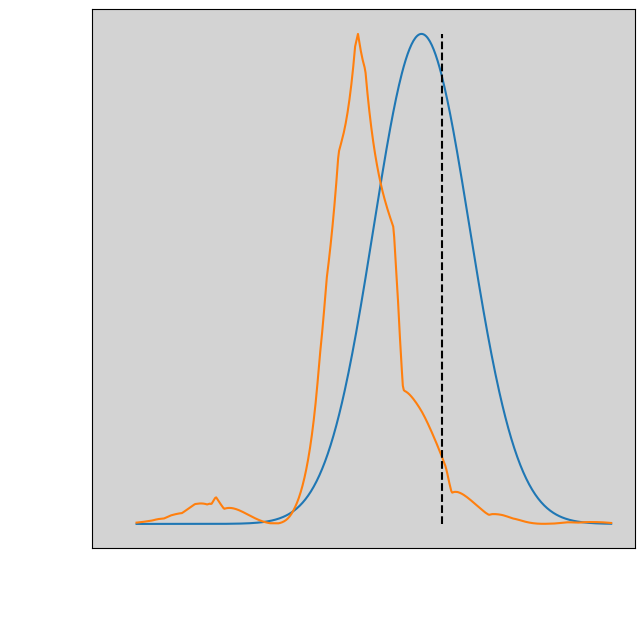

In [685]:
fig,ax = plt.subplots(figsize=(7,7))
#plt.plot(H_0_samples,np.exp(-nlls_RDRW)/(np.exp(-nlls_RDRW)[:-1]*np.diff(H_0_samples)).sum())
plt.plot(H_0_samples,np.exp(-nlls_RDRW))
plt.plot(H_0_samples,np.exp(-nlls_DRW))
plt.vlines(74,0,1,color='k',linestyle='--')

plt.xlabel('Hubble rate, '+r'$H_0$',fontsize=25)
ax.set_xticks([70,72,74,76])
ax.set_yticks([0,0.5,1])
ax.tick_params(axis='both', which='major', labelsize=15)

plt.ylabel('Likelihood',fontsize=25)

set_style()
#set_style('H0_RDRW_DRW_likelihood')

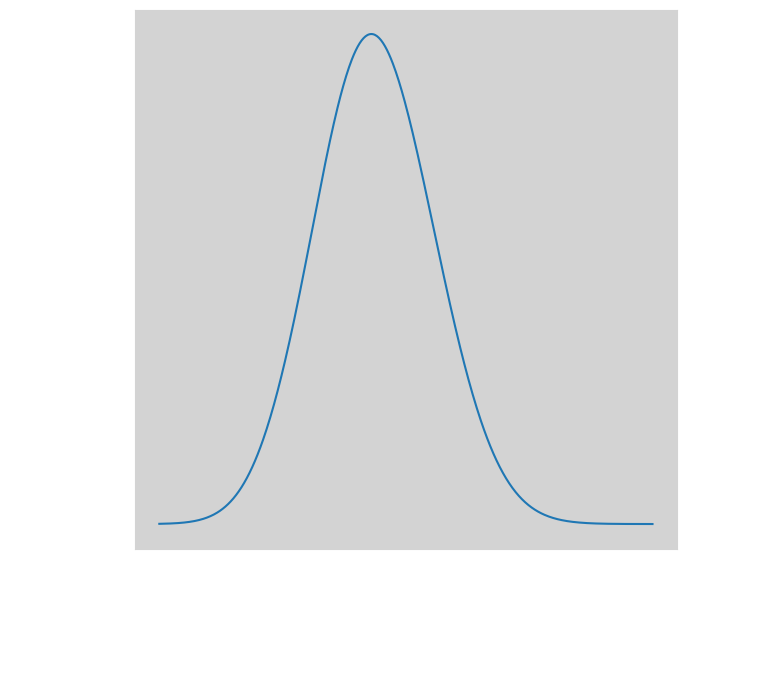

In [375]:
fig,ax = plt.subplots(figsize=(7,7))
#plt.plot(H_0_samples,np.exp(-nlls_RDRW)/(np.exp(-nlls_RDRW)[:-1]*np.diff(H_0_samples)).sum())
plt.plot(H_0_samples,np.exp(-nlls_RDRW))

plt.xlabel('Hubble rate, '+r'$H_0 \propto \phi(\vec{\theta}) / \Delta t$',fontsize=40)
ax.set_xticks([70,75,80])
ax.set_yticks([0,0.5,1])
ax.tick_params(axis='both', which='major', labelsize=25)

plt.ylabel('Likelihood',fontsize=40)

set_style()
#set_style('H0_RDRW_likelihood')

In [322]:
q = np.exp(-nlls_RDRW)/(np.exp(-nlls_RDRW)[:-1]*np.diff(H_0_samples)).sum()

In [319]:
H_0_samples

array([68.86511628, 68.88437835, 68.9036512 , 68.92293484, 68.94222927,
       68.96153451, 68.98085057, 69.00017745, 69.01951516, 69.03886371,
       69.05822312, 69.07759338, 69.09697451, 69.11636653, 69.13576943,
       69.15518323, 69.17460793, 69.19404355, 69.21349009, 69.23294757,
       69.25241599, 69.27189536, 69.2913857 , 69.310887  , 69.33039929,
       69.34992256, 69.36945683, 69.38900211, 69.40855841, 69.42812573,
       69.44770409, 69.4672935 , 69.48689396, 69.50650548, 69.52612808,
       69.54576175, 69.56540653, 69.5850624 , 69.60472938, 69.62440748,
       69.64409671, 69.66379709, 69.68350861, 69.70323128, 69.72296513,
       69.74271015, 69.76246636, 69.78223377, 69.80201238, 69.8218022 ,
       69.84160325, 69.86141554, 69.88123906, 69.90107384, 69.92091989,
       69.9407772 , 69.9606458 , 69.98052569, 70.00041688, 70.02031939,
       70.04023321, 70.06015836, 70.08009485, 70.1000427 , 70.1200019 ,
       70.13997247, 70.15995442, 70.17994776, 70.19995249, 70.21

In [ ]:
lensing_nlls =

In [283]:
lensing_loss(lensing_true_temp.x)

DeviceArray(116.75981709, dtype=float64)

In [286]:
hess_matr = hess(lensing_true_temp.x)

In [287]:
1/(hess_matr[0,0])

DeviceArray(13.39706252, dtype=float64)

In [272]:
covariance_matrix= jnp.linalg.inv(0.5*hess_matr[:2,:2])

import corner
# Sample a lot of points from the covariance matrix
def draw_from_gaussian(mu, S, ndraws=1):
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

samples_fisher = draw_from_gaussian(lensing_true_temp.x[:2], covariance_matrix, ndraws=10000)

In [280]:
covariance_matrix

DeviceArray([[ 3.53817921e+01, -7.13275610e-02],
             [-7.13275610e-02,  5.92433419e-04]], dtype=float64)

In [273]:
samples_fisher.shape

(10000, 2)

In [274]:
np.median(samples_fisher,axis=0)

array([-200.97343987,    1.97824913])

In [275]:
np.mean(samples_fisher,axis=0)

array([-201.0187789 ,    1.97822842])

In [276]:
np.std(samples_fisher,axis=0)

array([5.87680339, 0.02420349])

In [277]:
H_0_samples = 1/samples_fisher[:,0]
H_0_samples *= 74.03/np.median(H_0_samples)

<AxesSubplot:ylabel='Count'>

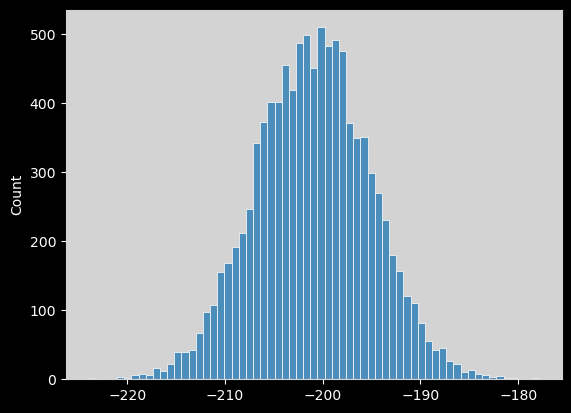

In [278]:
sns.histplot(samples_fisher[:,0])

<AxesSubplot:ylabel='Count'>

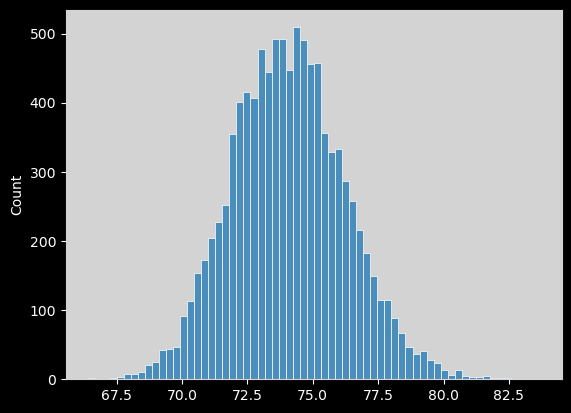

In [279]:
sns.histplot(H_0_samples)

In [252]:
lensing_loss = jax.jit(lambda x: loss(x,[0,0,326,0]))
grad = jax.grad(lensing_loss)
hess = jax.jacfwd(jax.jacrev(lensing_loss))
lensing_grad = lambda x: np.array(grad(x))

In [254]:
hess_matr = hess(lensing_DRW.x)

In [260]:
covariance_matrix= jnp.linalg.inv(0.5*hess_matr[:2,:2])

import corner
# Sample a lot of points from the covariance matrix
def draw_from_gaussian(mu, S, ndraws=1):
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

samples_fisher = draw_from_gaussian(lensing_DRW.x[:2], covariance_matrix, ndraws=10000)

In [261]:
samples_fisher.shape

(10000, 2)

In [262]:
np.median(samples_fisher,axis=0)

array([-202.82860506,    1.98513725])

In [263]:
np.mean(samples_fisher,axis=0)

array([-202.83511573,    1.9851343 ])

In [264]:
np.std(samples_fisher,axis=0)

array([5.08929752, 0.02558221])

In [265]:
H_0_samples = 1/samples_fisher[:,0]
H_0_samples *= 74.03/np.median(H_0_samples)

<AxesSubplot:ylabel='Count'>

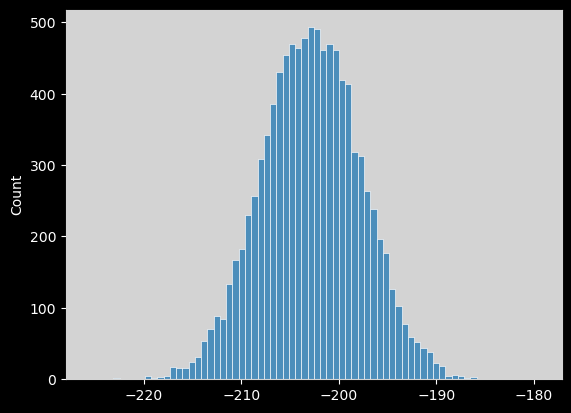

In [266]:
sns.histplot(samples_fisher[:,0])

<AxesSubplot:ylabel='Count'>

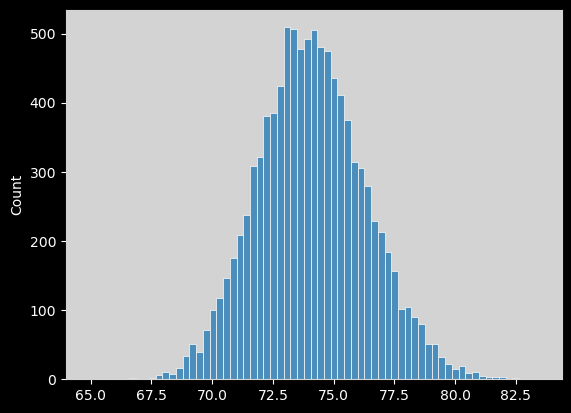

In [251]:
sns.histplot(H_0_samples)

<Figure size 1000x1000 with 0 Axes>

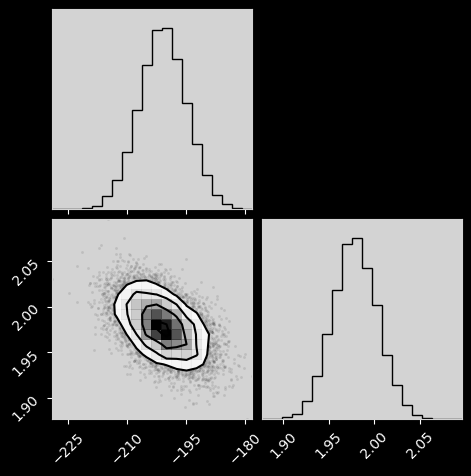

In [243]:
fig = plt.figure(figsize=(10, 10))
fig = corner.corner(samples_fisher)

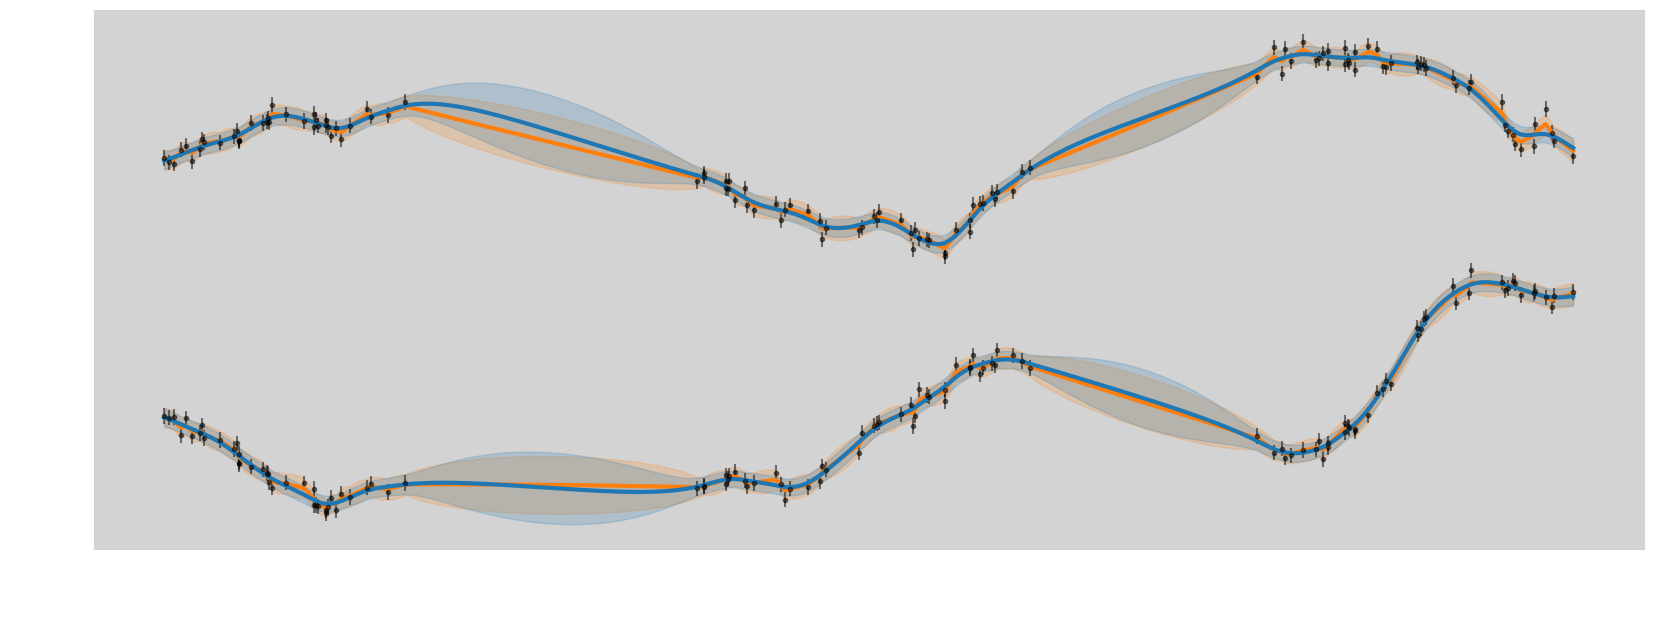

In [73]:
fig,ax = plt.subplots(figsize=(20,7))

ax.errorbar(context['time'],context['light_0'],context['err'],fmt='.',color='k',alpha=0.5,label='Light curve')
ax.errorbar(context['time'],context['light_1'],context['err'],fmt='.',color='k',alpha=0.5)

plot_GP(mean_DRW_0,variance_DRW_0,ax,color='C1',len=length,labels=['Damped Random Walk (DRW)',None],linewidth=3)
plot_GP(mean_DRW_1,variance_DRW_1,ax,color='C1',len=length,linewidth=3)

plot_GP(mean_true_0,variance_true_0,ax,color='C0',len=length,labels=['Reverberating DRW',None],linewidth=3)
plot_GP(mean_true_1,variance_true_1,ax,color='C0',len=length,linewidth=3)

"""
ax.annotate('Natural interpolation', xy=(310, 0.2),  xycoords='data',
            xytext=(490, 0.1), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05,color='C0'),
            horizontalalignment='right', verticalalignment='top',color='C0',fontsize=20
            )

ax.annotate('No overfitting', xy=(400, 0.9),  xycoords='data',
            xytext=(400, 0.5), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05,color='C0'),
            horizontalalignment='center', verticalalignment='top',color='C0',fontsize=20
            )
"""
#ax.legend(fontsize=20,framealpha=1,loc='lower left')
ax.set_ylabel('Magnitude',fontsize=20)
ax.set_xlabel('Time, [days]',fontsize=20)
#ax.set_xticks(np.arange(5)*365,np.arange(5))

ax.tick_params(axis='both', which='major', labelsize=12)
set_style()
#set_style('GP_for_lensed_curves')

Text(0.5, 1.0, 'Lensed Light curves')

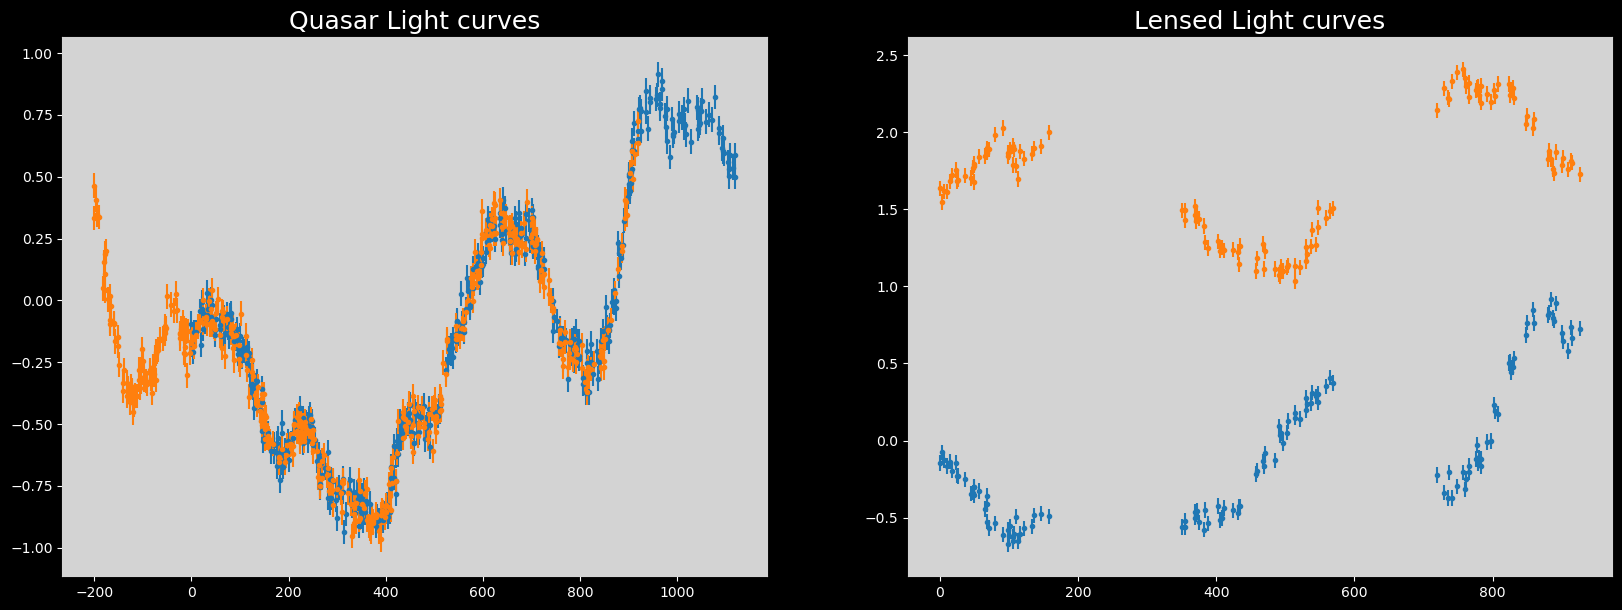

In [22]:

fig,ax=plt.subplots(1,2,figsize=(20,7))

mask_first = target['curve_index'].astype(bool)
ax[0].errorbar(target['time'][mask_first],target['light'][mask_first],target['err'][mask_first],fmt='.')
ax[0].errorbar(target['time'][~mask_first],target['light'][~mask_first],target['err'][~mask_first],fmt='.')
ax[0].set_title(label='Quasar Light curves',fontsize=FS)

ax[1].errorbar(context['time'],context['light_0'],context['err'],fmt='.')
ax[1].errorbar(context['time'],context['light_1'],context['err'],fmt='.')
ax[1].set_title(label='Lensed Light curves',fontsize=FS)